# Training and Testing Notebook NoDEAR

In [230]:
import pandas as pd
from collections import Counter
import os
import random
import numpy as np
import pickle
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
import seaborn as sns
import matplotlib.pyplot as plt


# Function to get the rates

In [247]:
def normalizeTargets(i,file,flag_file):
    ratefile =  os.path.join(file,file+flag_file)
    
    nTargets_1 =np.load(ratefile)
    


    return nTargets_1[i]

# Get the Minor allele Frequency and Derived Allele Frequency

In [258]:
def SNP_WINDOW(w,i,file,flag_file):
 
    rates = normalizeTargets(i,file,flag_file)
    targets= np.array(rates)
    
    
    lis_derived=[]
    lis_minor=[]

    for i in w:
        co = dict(Counter(i))
        
        
        ## Derived Allele Frequency
        if len(co.keys())==2:
            lis_derived.append(co[1]/len(i))
  
        
            
        ## Minor Allele Frequency
        if 0 in co.keys() and 1 in co.keys():
            if co[0]<co[1]:
                lis_minor.append(co[0]/(co[0]+co[1]))
            else:
                lis_minor.append(co[1]/(co[0]+co[1]))
 
    ## Break them into 20 bins
    bins = np.linspace(0, 1.0001, 20)


    bin_means_derived,bins_derived = np.histogram(lis_derived, bins, density=True)
    bin_means_minor,bins_minor = np.histogram(lis_minor, bins, density=True)
    
    
    ## Normalize the Bins
    bin_means_derived= bin_means_derived/bin_means_derived.sum()
    bin_means_minor= bin_means_minor/bin_means_minor.sum()
    
    
    #plt.bar(range(19), bin_means)
    #plt.show()

    return np.array(bins),targets,bin_means_derived,bin_means_minor[:10]


# Extract the Haplotype matrix from simulations

In [249]:
def __data_generation1(batchTreeIndices,file):

        haps = []
        pos = []
        rate =[]
        for treeIndex in batchTreeIndices:
            Hfilepath = os.path.join(file,str(treeIndex) + "_haps.npy")
            #Pfilepath = os.path.join(file, str(treeIndex) +"_pos.npy")
            H = np.load(Hfilepath)
            #P = np.load(Pfilepath)

            haps.append(H)
            #pos.append(P)

        return haps#,pos


            
def __getitem__1(idx,val):
    X= __data_generation1([idx],val)
    return X#,x1

# Find the L_2 norm with expected

In [250]:
def L_2(probabilities,n):

    import math
    from scipy.stats import entropy
    from sklearn.metrics.pairwise import cosine_similarity


    H_limit_raw = [1 / i for i in range(1, n+1)] 

    sum_H_limit_raw= sum(H_limit_raw)


    H_limit_vec = [v / sum_H_limit_raw for v in H_limit_raw]

    H_limit_vec= np.array(H_limit_vec).reshape(1,-1)
    probabilities=np.array(probabilities).reshape(1,-1)

    return np.linalg.norm(H_limit_vec - probabilities)

    


# Log the value

In [251]:
def logit_(val):
    ret_val=[]
    for i in range(len(val)):
           ret_val.append(np.log(val[i]))
            
    return ret_val
        

# Plot the results

In [238]:
def plotter(df,label_x,label_y,results_dic,file_name,dic):
                import seaborn as sns
                import pandas as pd
                import matplotlib.pyplot as plt
                from scipy.stats import spearmanr,pearsonr
                from sklearn.model_selection import cross_val_score
                from sklearn.model_selection import KFold
                from sklearn.metrics import r2_score
                from sklearn.metrics import mean_squared_error as MSE



                plt.figure(dpi=300)
                sns.regplot(x=label_x, y=label_y, data=df)
                min_val = min(df[label_x].min(), df[label_y].min())
                max_val = max(df[label_x].max(), df[label_y].max())


                plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
                rho_sp, p = spearmanr(df[label_x], df[label_y])
                plt.annotate(f'SpearmanR: {rho_sp:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, ha='left', va='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
                
                #plt.xlabel('')
                plt.savefig(file_name)
                plt.show()
                plt.clf()
                r2= r2_score(df[label_x], df[label_y])
                print("R2 Score:",r2)
               
                #rho_sp, p = spearmanr(dic[label_x], dic[label_y])
                print(fol)
                print('Speramanr:',rho_sp)
                rho_pr, p = pearsonr(df[label_x], df[label_y])
                print('Pearsonr:',rho_pr)
                loss = mean_squared_error(df[label_x], df[label_y])
                print(loss)
                abs_loss =mean_absolute_error(df[label_x], df[label_y])
                print(abs_loss)
                
                plt.show()
                plt.clf()
                results_dic['Folder']+=[file_name]
                results_dic['R2_Score']+=[r2_score(dic[label_x], dic[label_y])]
                results_dic['Pearson_Correlation']+=[rho_pr]
                results_dic['Spearman_Correlation']+=[rho_sp]
                results_dic['Mean_square_error']+=[loss]

                return results_dic

# Predict the rho value given Haplotype matrix , model flag ==1 (derived) , flag==0(minor)

In [236]:
def predit(H,model,flag):
    #H= ts.genotype_matrix()
    lis=[]
    valeeee=[]
    coee=0
    for i in H:
        co = dict(Counter(i))

            
        if flag==0:
            if 0 in co.keys() and 1 in co.keys():
                if co[0]<co[1]:
                    lis.append(co[0]/(co[0]+co[1]))
                else:
                    lis.append(co[1]/(co[0]+co[1]))
                coee=coee+1
        if flag==1:
            if len(co.keys())==2:
                lis.append(co[1]/len(i))
                coee=coee+1
            
                

    
    if flag==1:

        valeeee.append(coee/(len(H)+1))

        bins = np.linspace(0, 1.0001, 20)

        bin_means,bins = np.histogram(lis, bins, density=True)
        
        bin_means= bin_means/bin_means.sum()
        
    
    if flag==0:
        valeeee.append(coee/(len(H)+1))

        bins = np.linspace(0, 1.0001, 20)

        bin_means,bins = np.histogram(lis, bins, density=True)
        
        bin_means= bin_means/bin_means.sum()
        bin_means=bin_means[:10]

    #print(bin_means)

    pred = model.predict(pd.DataFrame([bin_means]))


    return pred,coee
    

# Running XGboos regressor , with 5- fold cross validaation 

In [237]:
def model_it(train_x,test_x,train_y,test_y,whole_x,whole_y,flag,file_,results_dic):
    import seaborn as sns
    from scipy.stats import spearmanr,pearsonr
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import KFold
    from sklearn.metrics import r2_score
    from sklearn.metrics import mean_squared_error as MSE
    import xgboost

    model = xgboost.XGBRegressor(objective ='reg:squarederror',n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
    cv = KFold(n_splits=5,  shuffle=True)

    score = cross_val_score(model, pd.DataFrame(whole_x), whole_y,scoring='r2',cv=cv)
    
    model = xgboost.XGBRegressor(objective ='reg:squarederror',n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
    
    model.fit(pd.DataFrame(train_x), train_y)
    pred = model.predict(pd.DataFrame(test_x))
    
    pred_df= pd.DataFrame(pred)
    true_df = pd.DataFrame(test_y)
    frames = [true_df, pred_df]


    result =pd.concat([true_df,pred_df], ignore_index=True,axis=1)
    sns.scatterplot(data=result,x=0,y=1)
    
    if flag==1:
        plt.xlabel("True rho")
        plt.ylabel("Predicted rho")
        plt.savefig('NoDear_traning_rho_partial_data'+file_+'.png')
    else:
        plt.xlabel("True c")
        plt.ylabel("Predicted c")
        plt.savefig('NoDear_traning_c_partial_data'+file_+'.png')

    # Show the plot
    plt.show()
    plt.clf()
    print("R2 Score:",r2_score(true_df, pred_df))
    print("MSE:",MSE(true_df, pred_df))
    rho_sp, p = spearmanr(pred_df,true_df)
    print('Speramanr:',rho_sp)
    rho_pr, p = pearsonr(pred,test_y)
    print('Pearsonr:',rho_pr)
    print('Cross Validation score:',score)
    results_dic['Folder']+=[file_]
    results_dic['R2_Score']+=[r2_score(true_df, pred_df)]
    results_dic['Pearson_Correlation']+=[rho_pr]
    results_dic['Spearman_Correlation']+=[rho_sp]
    results_dic['Mean_square_error']+=[MSE(true_df, pred_df)]
    results_dic['Cross_Validation_score']+=[score]
    
    
    return model,results_dic
    

# Load the data 

In [256]:
def load_data(file,flag_file):
    lis_train_minor=[]
    lis_train_derived=[]
    train_target_un=[]

    for i in range(10000):
            #print(i)
            x= __getitem__1(i,file)

            vale2,targets,vale_derived,vale_minor = SNP_WINDOW(x[0],i,file,flag_file)

            lis_train_minor.append(vale_minor)
            lis_train_derived.append(vale_derived)

            train_target_un.append(targets)
            
    return lis_train_minor,lis_train_derived,train_target_un

In [257]:
sim=['train_10k','train_50k','train_100k','train_150k','train_200k']
#sim=['train_50k']


#sim=['train_50k_100']

for simulations in sim:
    if simulations=='train_10k':
        flag_file="train_10k_rate.npy"
        file='/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/train_10k/'
        lis_train_10k_minor,lis_train_10k_derived,train_target_un_10k,train_target_z_10k,train_target_scaled_10k=load_data(file,flag_file)
    elif simulations=='train_50k':
        flag_file="train_50k_rate.npy"
        file='/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/train_50k/'
        lis_train_50k_minor,lis_train_50k_derived,train_target_un_50k,train_target_z_50k,train_target_scaled_50k=load_data(file,flag_file)
    elif simulations=='train_100k':
        flag_file="train_100k_rate.npy"
        file='/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/train_100k/'
        lis_train_100k_minor,lis_train_100k_derived,train_target_un_100k,train_target_z_100k,train_target_scaled_100k=load_data(file,flag_file)
    elif simulations=='train_150k':
        flag_file="train_150k_rate.npy"
        file='/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/train_150k/'
        lis_train_150k_minor,lis_train_150k_derived,train_target_un_150k,train_target_z_150k,train_target_scaled_150k=load_data(file,flag_file)
    elif simulations=='train_200k':
        flag_file="train_200k_rate.npy"
        file='/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/train_200k/'
        lis_train_200k_minor,lis_train_200k_derived,train_target_un_200k,train_target_z_200k,train_target_scaled_200k=load_data(file,flag_file)

       

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217


KeyboardInterrupt: 

# Plot the derived AFS for higher and lower recombination windows

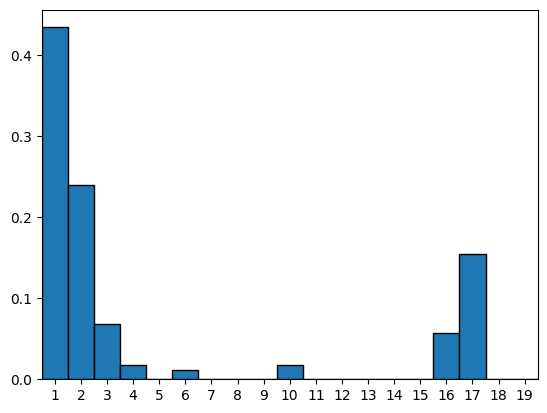

<Figure size 640x480 with 0 Axes>

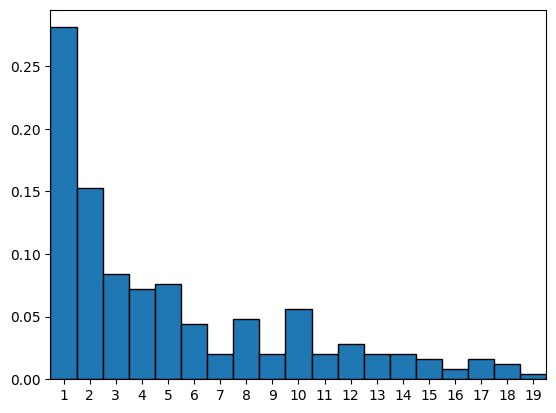

<Figure size 640x480 with 0 Axes>

In [226]:

bins = np.arange(len(lis_train_50k_derived[0]))
#rho=train_target_un_50k[0]
#number_tree_changes=3.597739657143682*train_target_un_50k[0]
# Plotting the histogram-like plot
plt.bar(range(1,20,1), lis_train_50k_derived[0], width=1.0, edgecolor='black') 
#plt.title('Derived Allele Frequency Spectrum Low recombination region')
#plt.xlabel('Derived Allele Frequency')
#plt.ylabel('Frequency')
plt.xticks(range(1,20,1))
plt.margins(x=0)
plt.savefig('Low_recombination.png')
plt.show()
plt.clf()   
plt.show()



bins = np.arange(len(lis_train_50k_derived[-1]))
#rho=train_target_un_50k[-1]
#number_tree_changes=3.597739657143682*train_target_un_50k[-1]
# Plotting the histogram-like plot
plt.bar(range(1,20,1), lis_train_50k_derived[-1], width=1.0, edgecolor='black') 
#plt.title('Derived Allele Frequency Spectrum High recombination region')
#plt.xlabel('Derived Allele Frequency')
#plt.ylabel('Frequency')
plt.xticks(range(1,20,1))

plt.margins(x=0)
plt.savefig('High_recombination.png')
plt.show()
plt.clf()   
plt.show()




## Get L-2 norm for minor and derived AFS

In [259]:
lis_train_50k_H_minor= [L_2(i,10) for i in lis_train_50k_minor]
lis_train_50k_H_derived= [L_2(i,19) for i in lis_train_50k_derived]


In [67]:
print('L-2, Low recombination',lis_train_50k_H_derived[0])
print('L-2, High recombination',lis_train_50k_H_derived[-1])

L-2, Low recombination 0.2614713186595328
L-2, High recombination 0.049092261412744115


# Correlation between Log-L-2 norm and Rho value

########################### Derived ################################


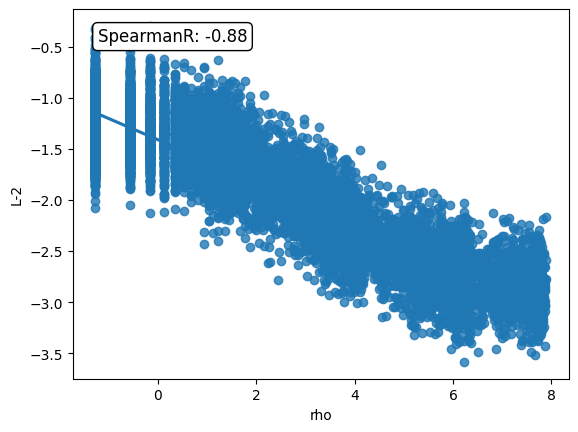

########################### Minor ################################


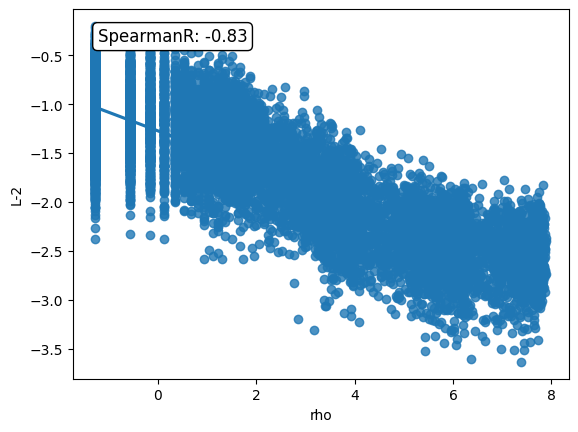

<Figure size 640x480 with 0 Axes>

In [234]:
print('########################### Derived ################################')
df=pd.DataFrame({'L-2':np.log(lis_train_50k_H_derived),'rho':np.log(train_target_un_50k)})
sns.regplot(x='rho', y='L-2', data=df)
from scipy.stats import spearmanr,pearsonr
from sklearn.metrics import r2_score
#plt.xlabel('log(L-2 Norm derived)')
#plt.ylabel('log(rho)')
rho_sp,p=spearmanr(df['L-2'],df['rho'])
plt.annotate(f'SpearmanR: {rho_sp:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, ha='left', va='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.savefig('L-2 Norm derived.png')
plt.show()
plt.clf()   



print('########################### Minor ################################')
df=pd.DataFrame({'L-2':np.log(lis_train_50k_H_minor),'rho':np.log(train_target_un_50k)})
sns.regplot(x='rho', y='L-2', data=df)
from scipy.stats import spearmanr,pearsonr
from sklearn.metrics import r2_score
#plt.xlabel('log(L-2 Norm Minor)')
#plt.ylabel('log(rho)')
rho_sp,p=spearmanr(df['L-2'],df['rho'])
plt.annotate(f'SpearmanR: {rho_sp:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, ha='left', va='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.savefig('L-2 Norm minor.png')
plt.show()
plt.clf()   


# Training Process

50k


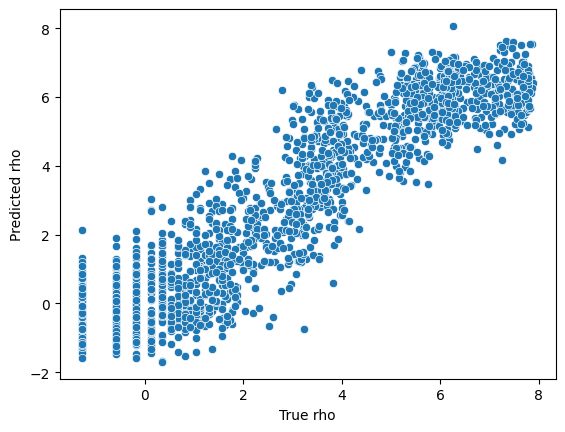

R2 Score: 0.86753074459916
MSE: 1.1077397350692182
Speramanr: 0.9046797389463411
Pearsonr: 0.931602781766426
Cross Validation score: [0.87446454 0.87859363 0.87366742 0.87538871 0.88352053]


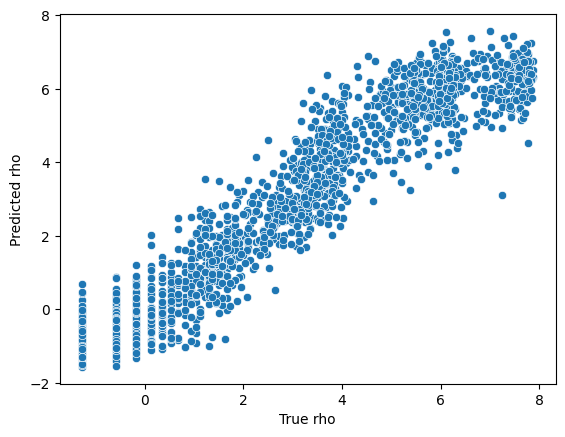

R2 Score: 0.9235256002902225
MSE: 0.6577765851378403
Speramanr: 0.9461549943883417
Pearsonr: 0.9611209740653149
Cross Validation score: [0.92271821 0.91730788 0.91728075 0.91600837 0.91873019]
46.11309194564819


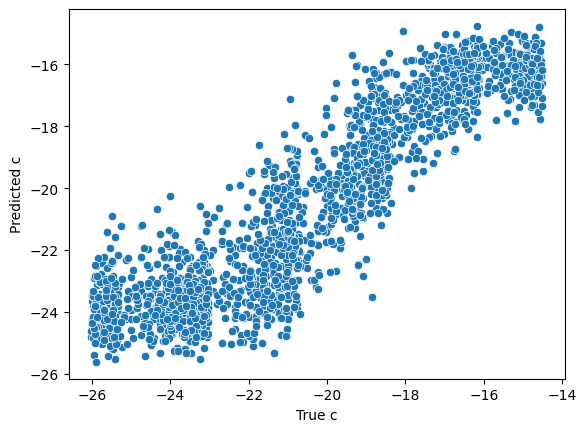

R2 Score: 0.8387676651636572
MSE: 1.8159059993686975
Speramanr: 0.9052990614142525
Pearsonr: 0.91612207467236
Cross Validation score: [0.83836688 0.83469527 0.83126647 0.8407493  0.83932784]


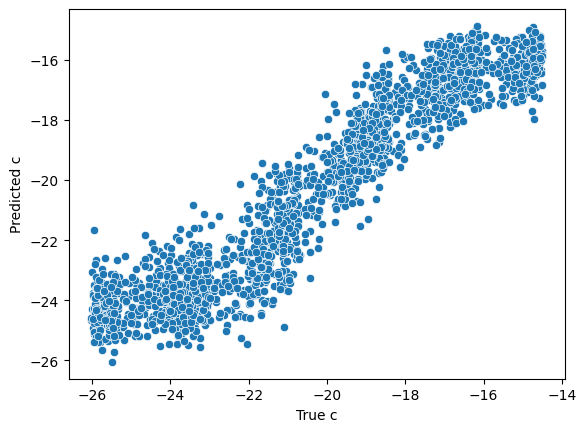

R2 Score: 0.8944015931480924
MSE: 1.2085828743495677
Speramanr: 0.9366776191694047
Pearsonr: 0.9457699728438898
Cross Validation score: [0.88330299 0.88869883 0.88144877 0.88645875 0.88332241]


"\nimport xgboost\nmodel = xgboost.XGBRegressor(objective ='reg:squarederror',n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)\n\n    \nmodel.fit(pd.DataFrame(lis_train_50k), logit_(train_target_un_50k))\n\n\n\nprint('50k')\nnTa =np.load('./non_eq_train/non_eq_train_rec_rate.npy',allow_pickle=True)\n\nX_train_50k, X_test_50k, y_train_50k, y_test_50k = train_test_split(lis_train_non_eq, logit_(train_target_un_non_eq), test_size=0.2)\nmodel=model_it(X_train_50k, X_test_50k, y_train_50k, y_test_50k,lis_train_non_eq, logit_(train_target_un_non_eq),1,'50k')\n\n\nX_train_50k, X_test_50k, y_train_50k, y_test_50k = train_test_split(lis_train_non_eq, logit_(nTa), test_size=0.2)\nmodel1=model_it(X_train_50k, X_test_50k, y_train_50k, y_test_50k,lis_train_non_eq, logit_(nTa),0,'50k')\n"

<Figure size 640x480 with 0 Axes>

In [169]:
from sklearn.model_selection import train_test_split
import time

results_dic = {'Folder':[], 'R2_Score':[], 'Pearson_Correlation':[], 'Spearman_Correlation':[],'Mean_square_error':[],'Cross_Validation_score':[]}



sim=['train_10k','train_50k','train_100k','train_150k','train_200k']

model_dic={'train_10k':[],'train_50k':[],'train_100k':[],'train_150k':[],'train_200k':[]}

#sim=['train_50k']

#model_dic={'train_50k':[]}

for simulations in sim:
    if simulations=='train_10k':
        print('10k')
        file_rate ='/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/'+simulations+'/'+simulations+'_rec_rate.npy'
        nTa =np.load(file_rate,allow_pickle=True)
        x_value_minor=lis_train_10k_minor
        x_value_derived=lis_train_10k_derived
        y_value=train_target_un_10k
        flag='10k'
    elif simulations=='train_50k':
        print('50k')
        file_rate ='/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/'+simulations+'/'+simulations+'_rec_rate.npy'
        nTa =np.load(file_rate,allow_pickle=True)
        x_value_minor=lis_train_50k_minor
        x_value_derived=lis_train_50k_derived
        y_value=train_target_un_50k
        flag='50k'
    elif simulations=='train_100k':
        print('100k')
        file_rate ='/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/'+simulations+'/'+simulations+'_rec_rate.npy'
        nTa =np.load(file_rate,allow_pickle=True)
        x_value_minor=lis_train_100k_minor
        x_value_derived=lis_train_100k_derived
        y_value=train_target_un_100k
        flag='100k'
    elif simulations=='train_150k':
        print('150k')
        file_rate ='/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/'+simulations+'/'+simulations+'_rec_rate.npy'
        nTa =np.load(file_rate,allow_pickle=True)
        x_value_minor=lis_train_150k_minor
        x_value_derived=lis_train_150k_derived
        y_value=train_target_un_150k
        flag='150k'
    elif simulations=='train_200k':
        print('200k')
        file_rate ='/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/'+simulations+'/'+simulations+'_rec_rate.npy'
        nTa =np.load(file_rate,allow_pickle=True)
        x_value_minor=lis_train_200k_minor
        x_value_derived=lis_train_200k_derived
        y_value=train_target_un_200k
        flag='200k'

    X_train, X_test, y_train, y_test = train_test_split(x_value_minor, logit_(y_value), test_size=0.2)
    model_rho_minor,results_dic=model_it(X_train, X_test, y_train, y_test,x_value_minor, logit_(y_value),1,flag+'_rho_minor',results_dic)
    model_dic[simulations]+=[model_rho_minor]
    
    start = time.time()
    X_train, X_test, y_train, y_test = train_test_split(x_value_derived, logit_(y_value), test_size=0.2)
    model_rho_derived,results_dic=model_it(X_train, X_test, y_train, y_test,x_value_derived, logit_(y_value),1,flag+'_rho_derived',results_dic)
    model_dic[simulations]+=[model_rho_derived]
    end = time.time()
    time_=end-start
    print(time_)
    X_train, X_test, y_train, y_test = train_test_split(x_value_minor, logit_(nTa), test_size=0.2)
    model_c_minor,results_dic=model_it(X_train, X_test, y_train, y_test,x_value_minor, logit_(nTa),0,flag+'_c_minor',results_dic)
    model_dic[simulations]+=[model_c_minor]
    
    X_train, X_test, y_train, y_test = train_test_split(x_value_derived, logit_(nTa), test_size=0.2)
    model_c_derived,results_dic=model_it(X_train, X_test, y_train, y_test,x_value_derived, logit_(nTa),0,flag+'_c_derived',results_dic)
    model_dic[simulations]+=[model_c_derived]
    
    result_df= pd.DataFrame(results_dic)


    result_df.to_csv('training_stats.csv', index=False)
    


# Testing on Simulated Dataset

<Figure size 640x480 with 0 Axes>

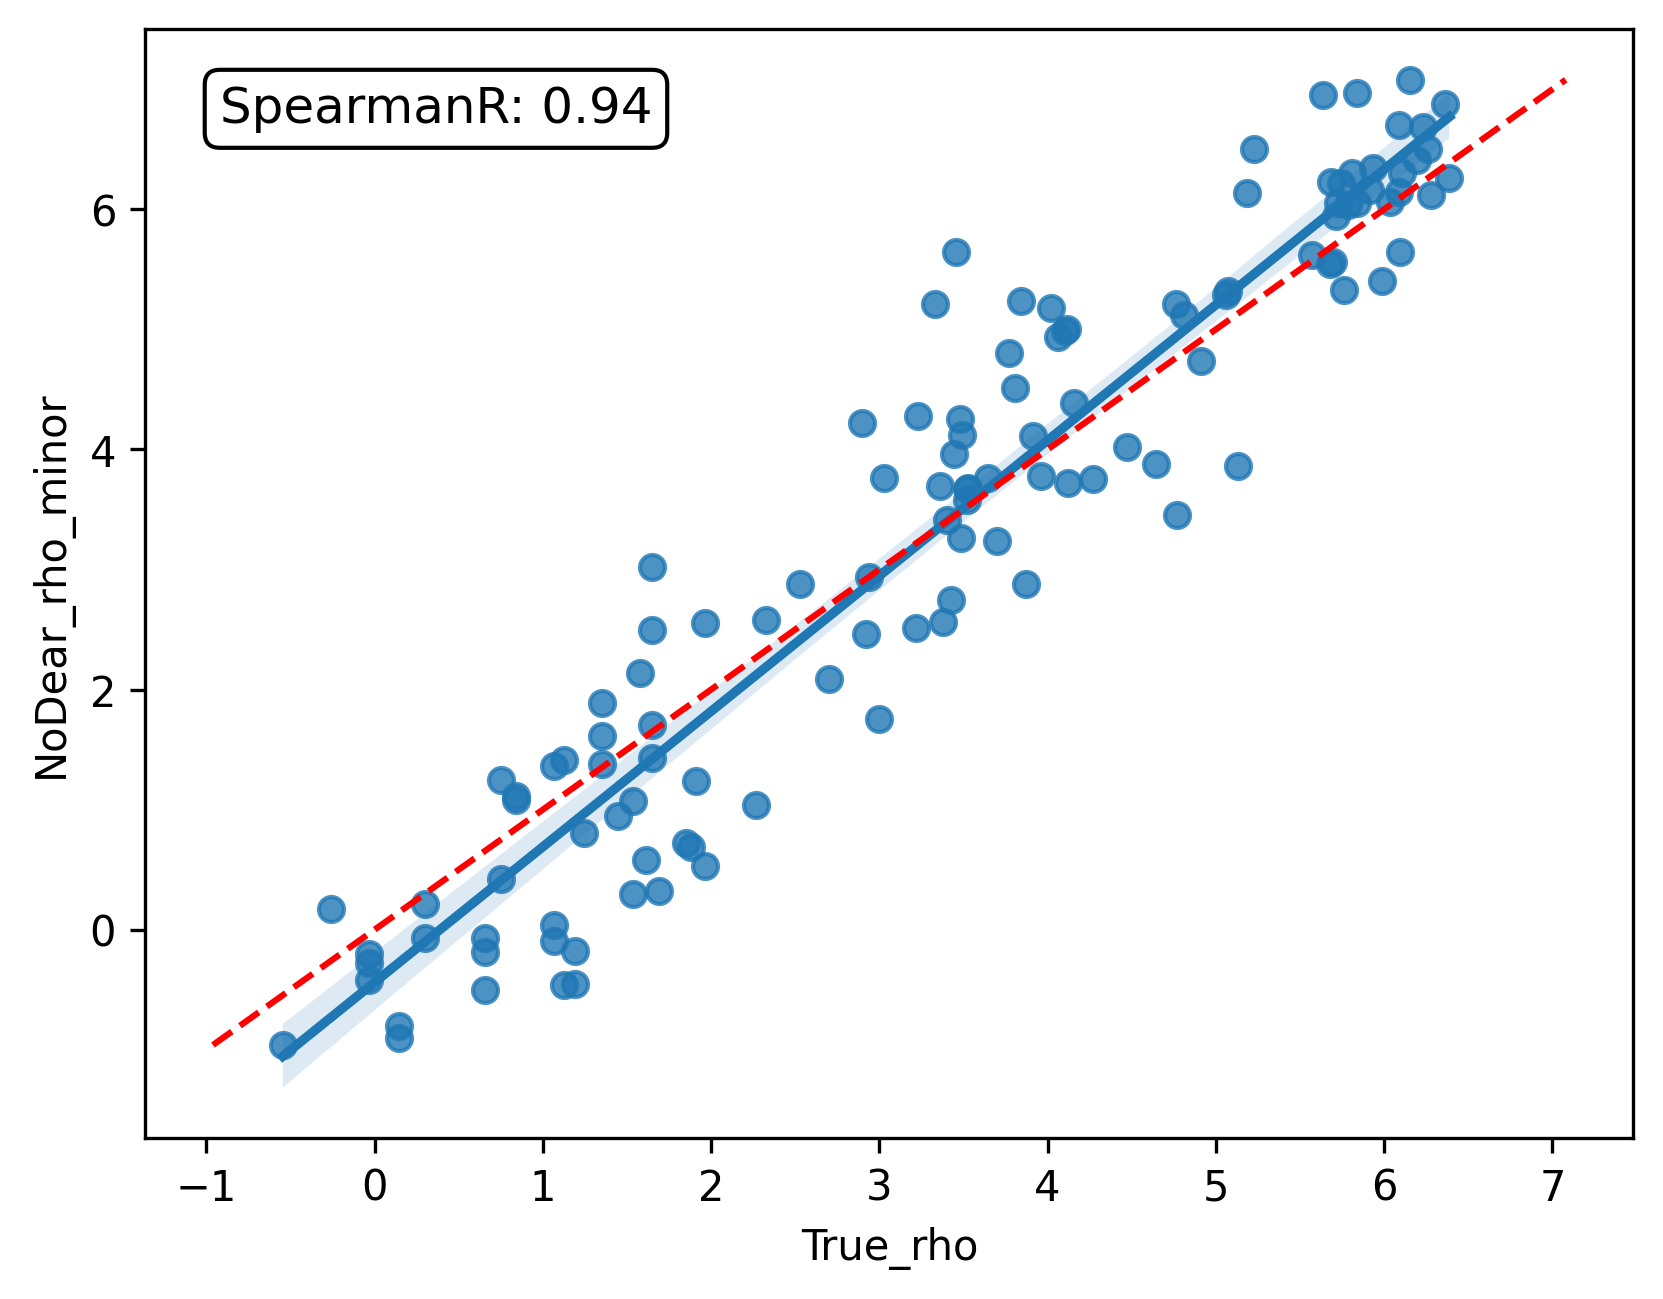

R2 Score: 0.8488039878273954
./eqtes_50k_100/
Speramanr: 0.9434508738332179
Pearsonr: 0.9510044855725163
0.5925245784163562
0.6189983062105988


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

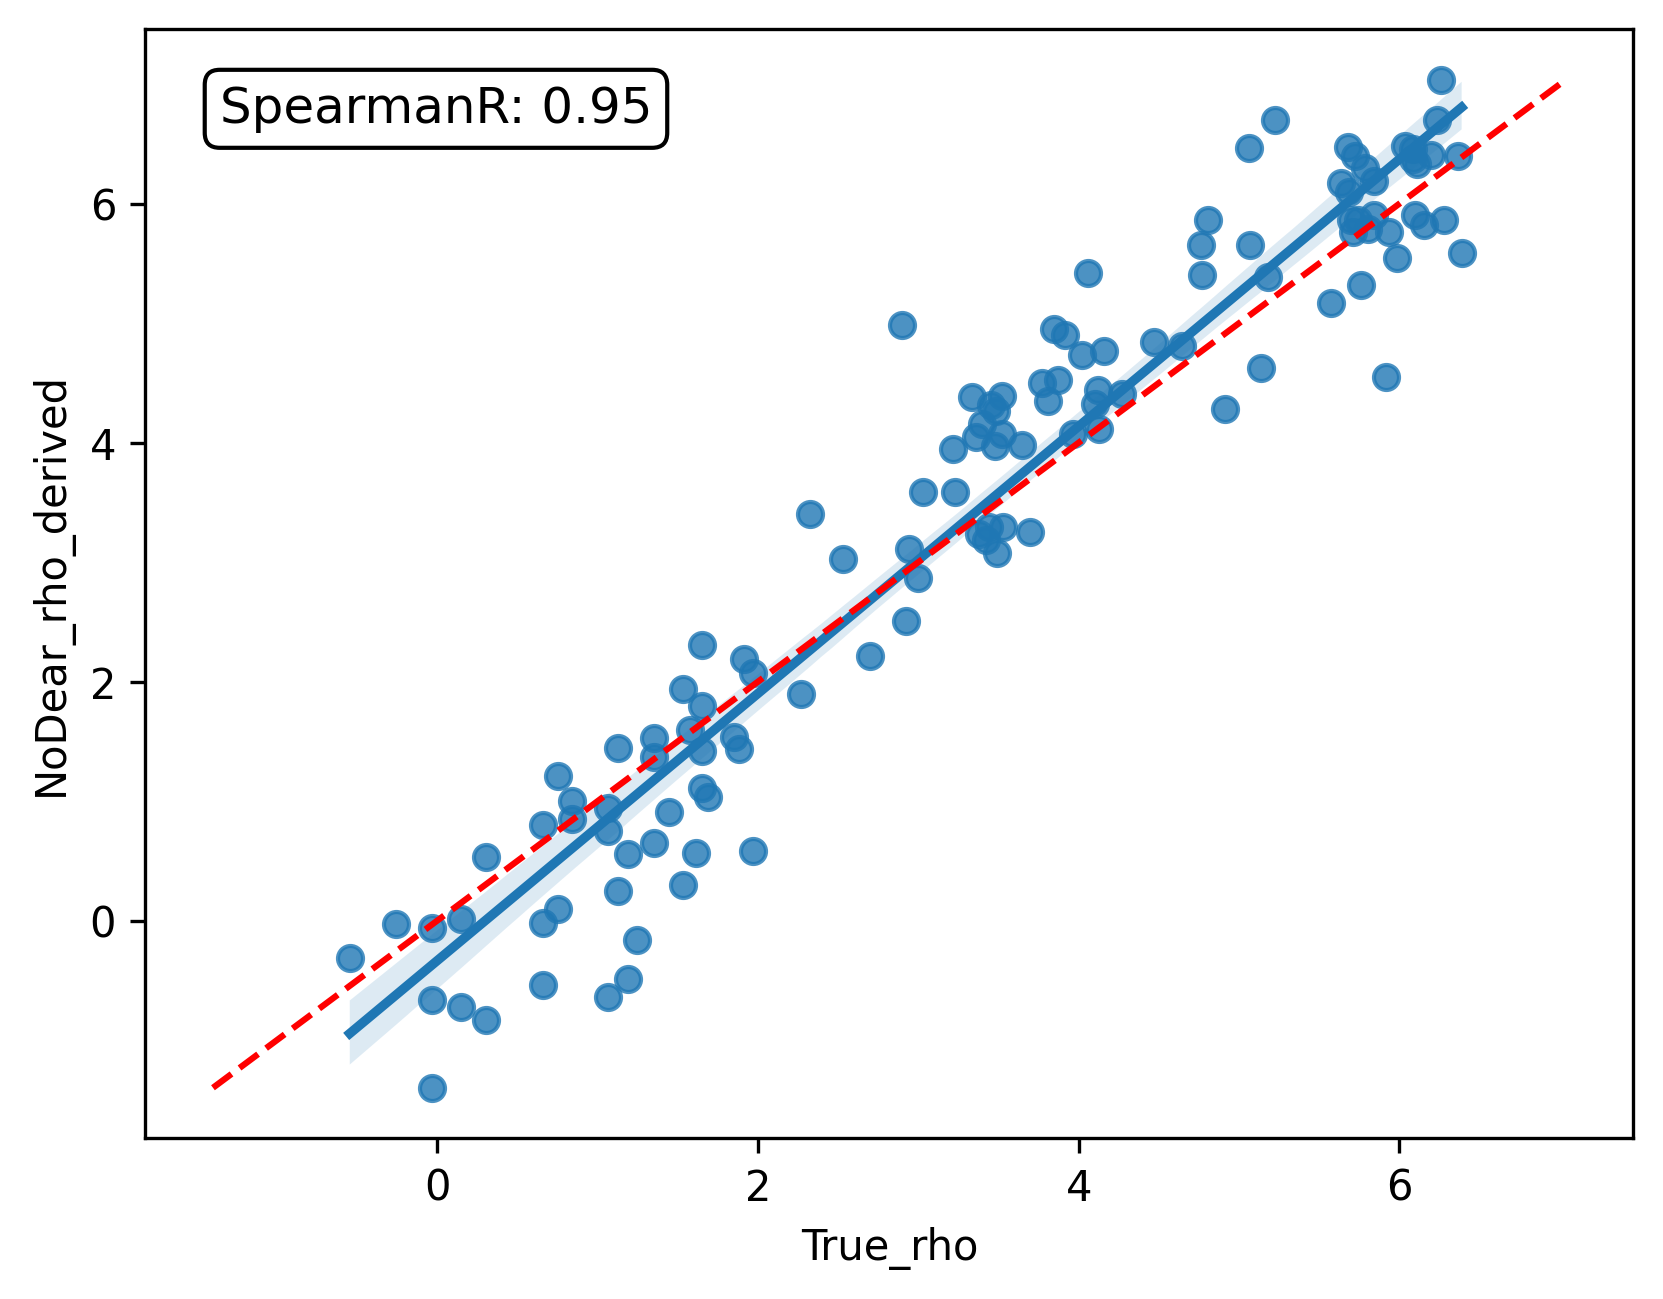

R2 Score: 0.8790893740793312
./eqtes_50k_100/
Speramanr: 0.9521881377948357
Pearsonr: 0.9600399243658091
0.47383867219933873
0.546339366935531


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

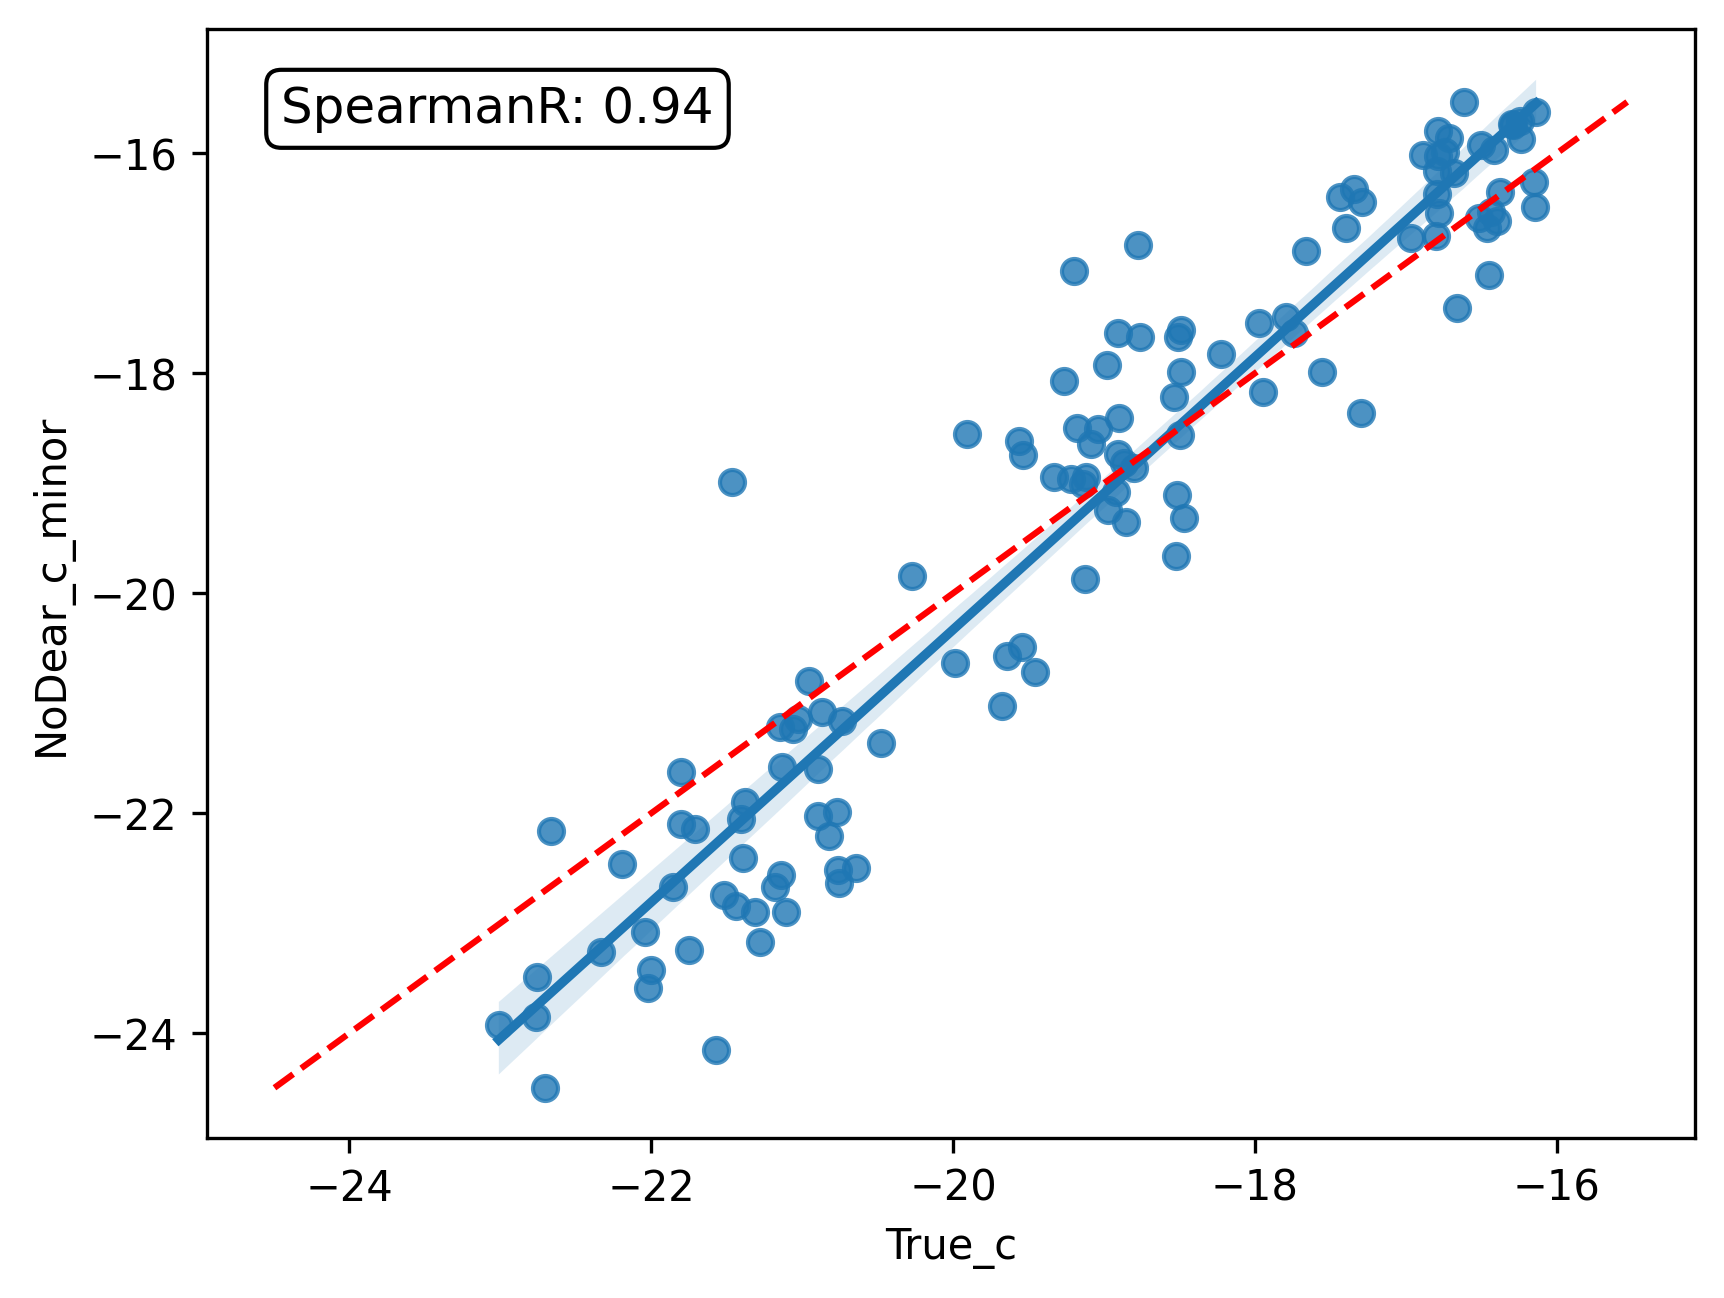

R2 Score: 0.773632005150056
./eqtes_50k_100/
Speramanr: 0.9402111257726229
Pearsonr: 0.9503115526550748
0.8987358218552174
0.7694324148502267


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

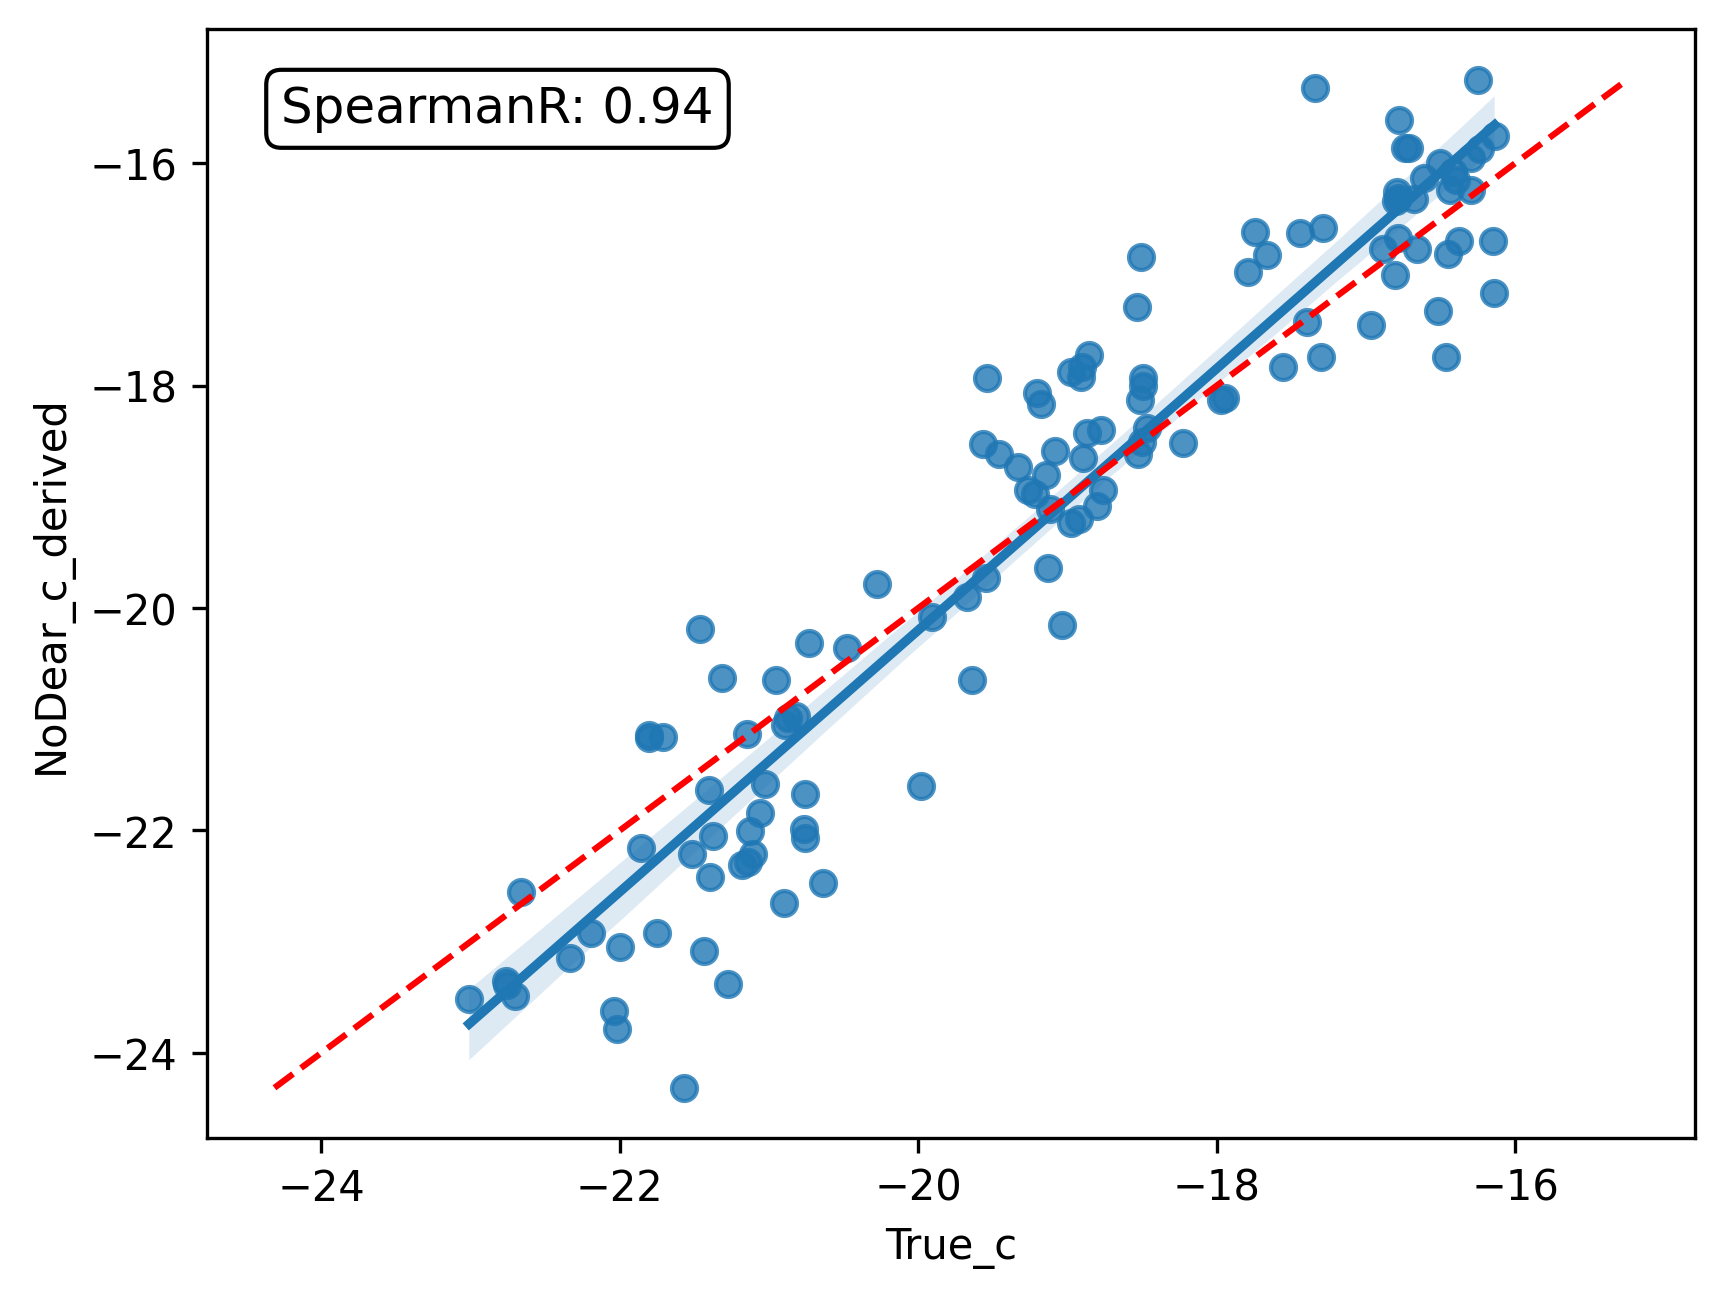

R2 Score: 0.8131460688288419
./eqtes_50k_100/
Speramanr: 0.9440100006944926
Pearsonr: 0.9483171445161378
0.7418554089738213
0.6874398927860939


<Figure size 640x480 with 0 Axes>

time 2.072679042816162


<Figure size 640x480 with 0 Axes>

In [60]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
import time
results_dic = {'Folder':[], 'R2_Score':[], 'Pearson_Correlation':[], 'Spearman_Correlation':[],'Mean_square_error':[]}

sim=['train_10k','train_50k','train_100k','train_150k','train_200k']
#sim=['train_50k_100']

#folder= ['./non_eq_tes/','./eq_tes/','./gene_conversion_eq/','./pop_split/']
folder=['./popspliteq_10k/', './popspliteq_50k/', './popspliteq_100k/', './popspliteq_150k/', './popspliteq_200k/', './eqtes_10k/', './eqtes_50k/', './eqtes_100k/', './eqtes_150k/', './eqtes_200k/', './noneqtes_10k/', './noneqtes_50k/', './noneqtes_100k/', './noneqtes_150k/', './noneqtes_200k/', './geneconversioneq_10k/', './geneconversioneq_50k/', './geneconversioneq_100k/', './geneconversioneq_150k/', './geneconversioneq_200k/']
#folder =['./eqtes_50k_100/']
time_=[]
for simulations in sim:
        model_list = model_dic[simulations]
        window_size= simulations.split('_')[1]
        #for model_index in range(len(model_list)):
        
        for fol in folder:
            if fol[2:-1].split('_')[1]==window_size:
                ro_minor=[]
                ro_derived=[]
                
                c_minor=[]
                c_derived=[]
                true_rho= np.load('/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear'+fol[1:]+fol[2:-1]+'_rate.npy')
                true_c= np.load('/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear'+fol[1:]+fol[2:-1]+'_rec_rate.npy')
                
                rho=[]
                c=[]
                for i in range(120):
                    
                        ha= np.load('/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/'+fol[1:]+str(i)+'_haps.npy')
                        rho.append(np.log(true_rho[i]))
                        c.append(np.log(true_c[i]))


                        ro_minor.append(predit(ha,model_list[0],0))
                        start_time= time.time()
                        ro_derived.append(predit(ha,model_list[1],1))
                        time_.append(time.time()-start_time)
                        
                        c_minor.append(predit(ha,model_list[2],0))
                        c_derived.append(predit(ha,model_list[3],1))


                dic_minor_ro = {'True_rho': np.array(rho), 'NoDear_rho_minor': [x[0][0] for x in ro_minor]}
                dic_derived_ro= {'True_rho': np.array(rho), 'NoDear_rho_derived': [x[0][0] for x in ro_derived]}

                
                dic_minor_c = {'True_c': np.array(c), 'NoDear_c_minor': [x[0][0] for x in c_minor]}
                dic_derived_c= {'True_c': np.array(c), 'NoDear_c_derived': [x[0][0] for x in c_derived]}


                df_minor_ro = pd.DataFrame(dic_minor_ro)
                df_minor_ro.to_csv('NoDear'+fol[2:-1]+'_minor_rho.csv', index=False)
                
                df_derived_ro = pd.DataFrame(dic_derived_ro)
                df_derived_ro.to_csv('NoDear'+fol[2:-1]+'_derived_rho.csv', index=False)
                
                df_minor_c = pd.DataFrame(dic_minor_c)
                df_minor_c.to_csv('NoDear'+fol[2:-1]+'_minor_c.csv', index=False)
                
                
                df_derived_c = pd.DataFrame(dic_derived_c)
                df_derived_c.to_csv('NoDear'+fol[2:-1]+'_derived_c.csv', index=False)
        





                
                plt.clf()
                results_dic= plotter(df_minor_ro,'True_rho','NoDear_rho_minor',results_dic,fol[2:-1]+'_NoDear_minor_rho',dic_minor_ro)
                results_dic= plotter(df_derived_ro,'True_rho','NoDear_rho_derived',results_dic,fol[2:-1]+'_NoDear_derived_rho',dic_derived_ro)
                
                results_dic= plotter(df_minor_c,'True_c','NoDear_c_minor',results_dic,fol[2:-1]+'_NoDear_minor_c',dic_minor_c)
                results_dic= plotter(df_derived_c,'True_c','NoDear_c_derived',results_dic,fol[2:-1]+'_NoDear_derived_c',dic_derived_c)
                
                results_df= pd.DataFrame(results_dic)
                results_df.to_csv('testing_stats_100.csv', index=False)
print('time',sum(time_))

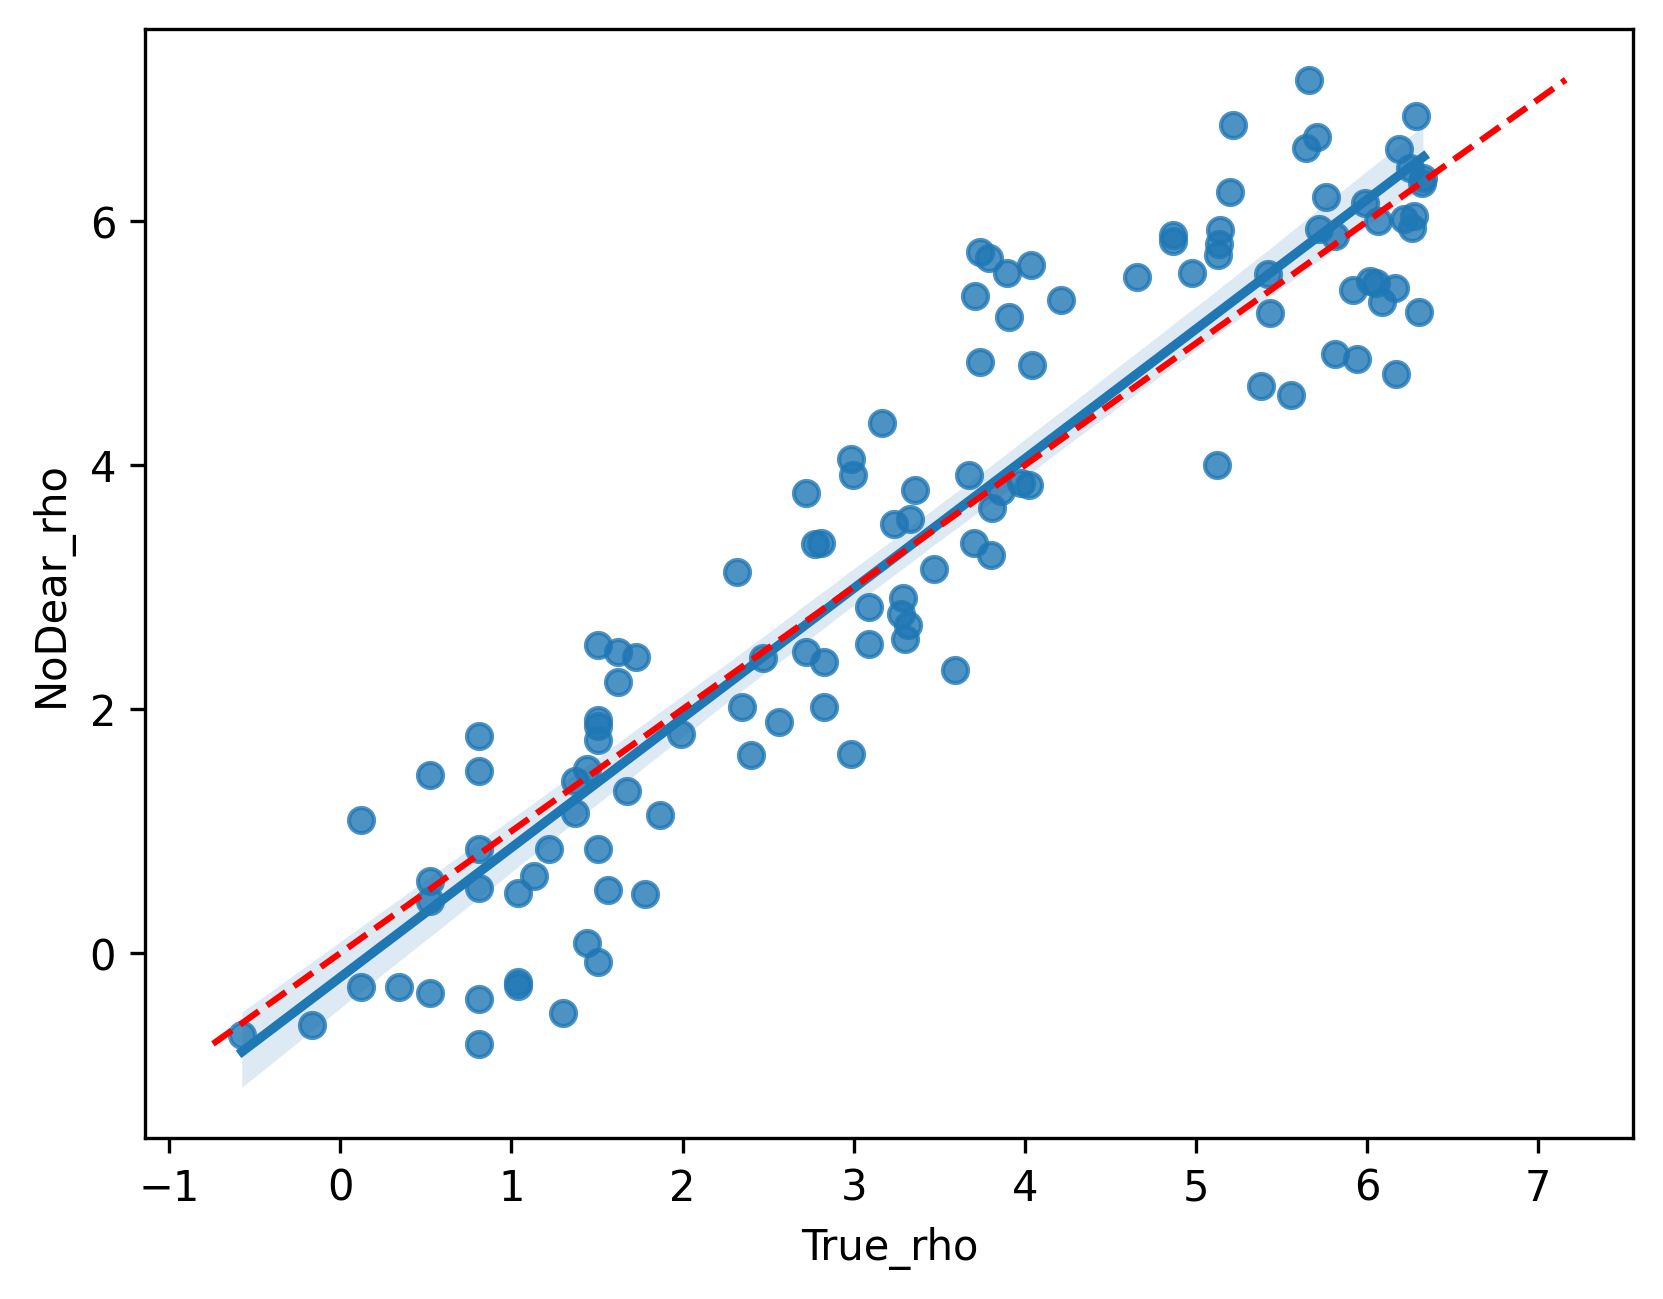

R2 Score: 0.8131717988141142
./eqtes_50k_100/
Speramanr: 0.9227130690405193
Pearsonr: 0.9277253932303624
0.7072628987104117
0.6924774816561423


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

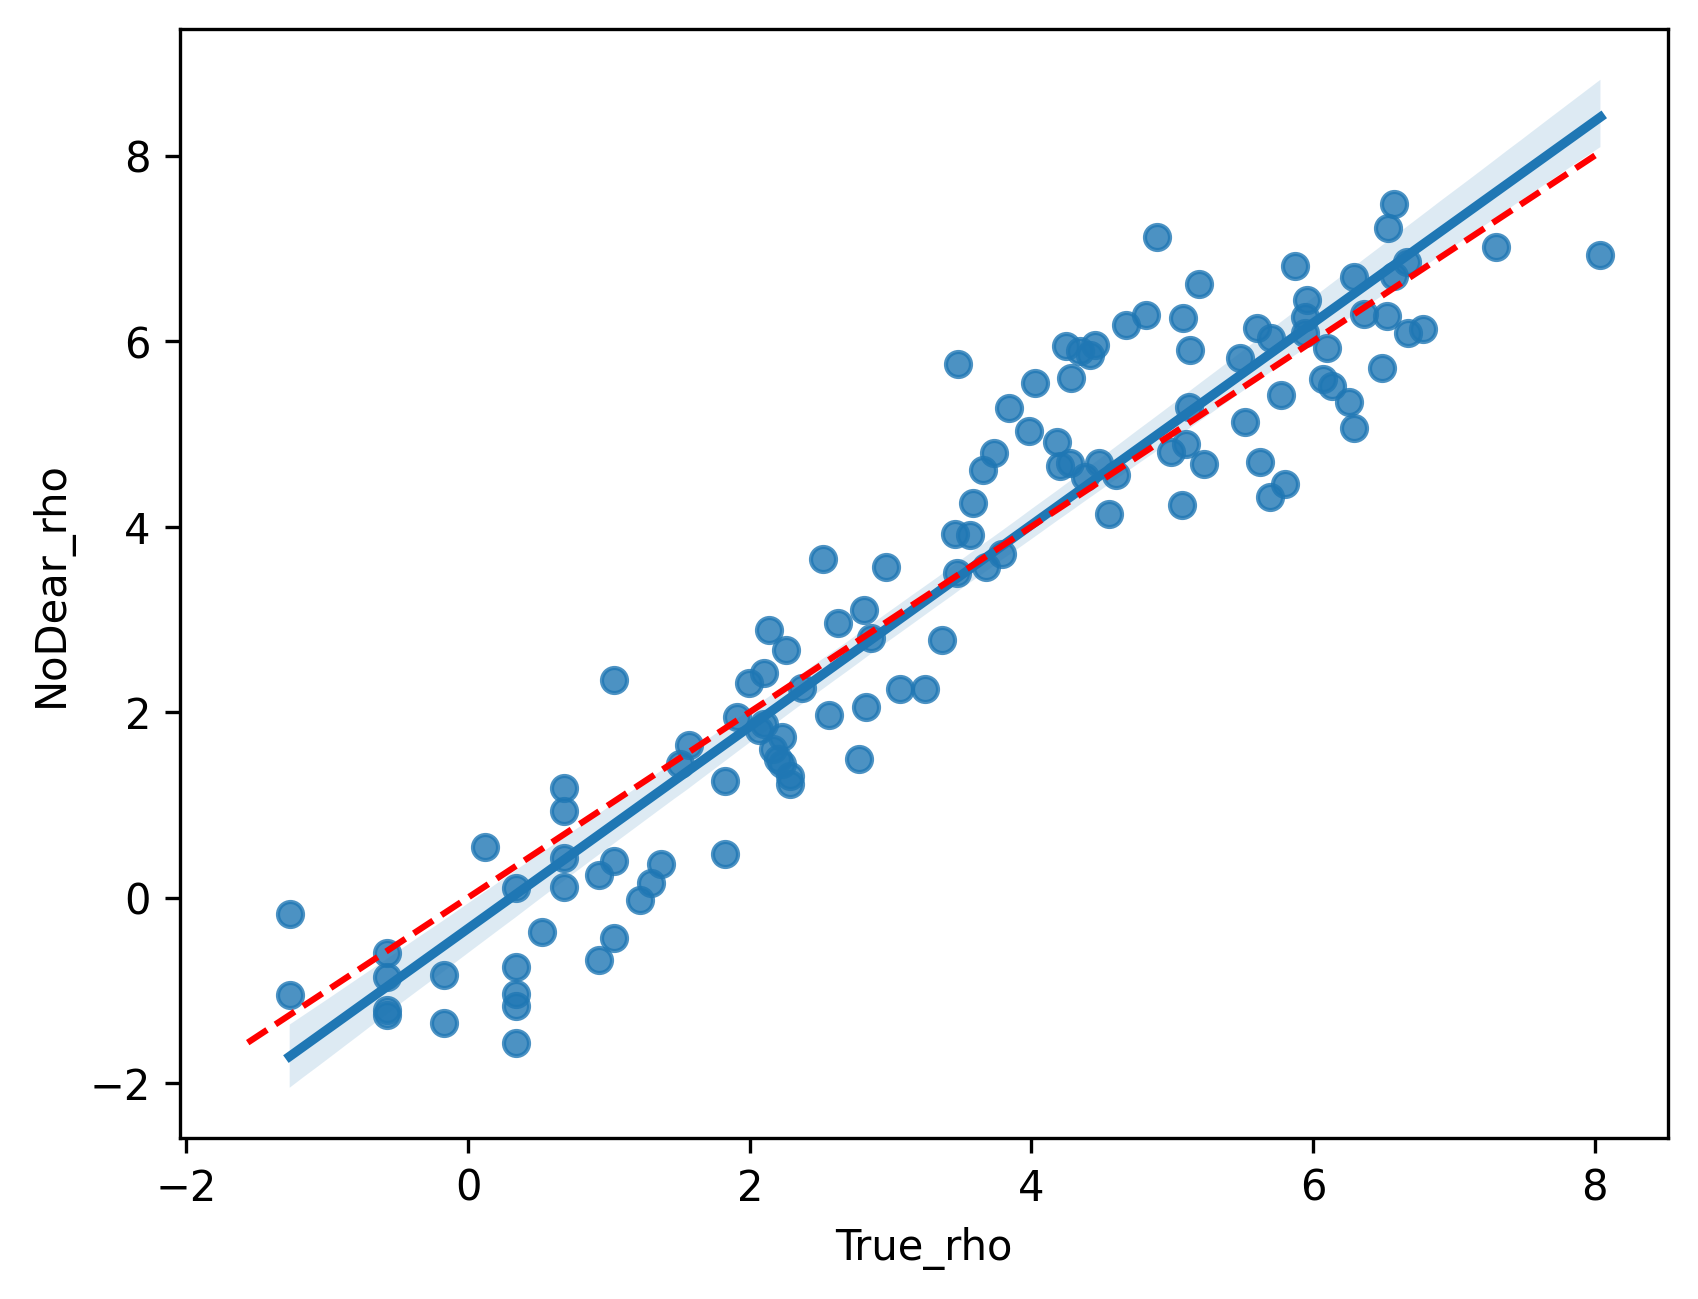

R2 Score: 0.8408510710703294
./eqtes_50k_100/
Speramanr: 0.9321715793727849
Pearsonr: 0.9417226851026743
0.7818313322565926
0.7242440833814707


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

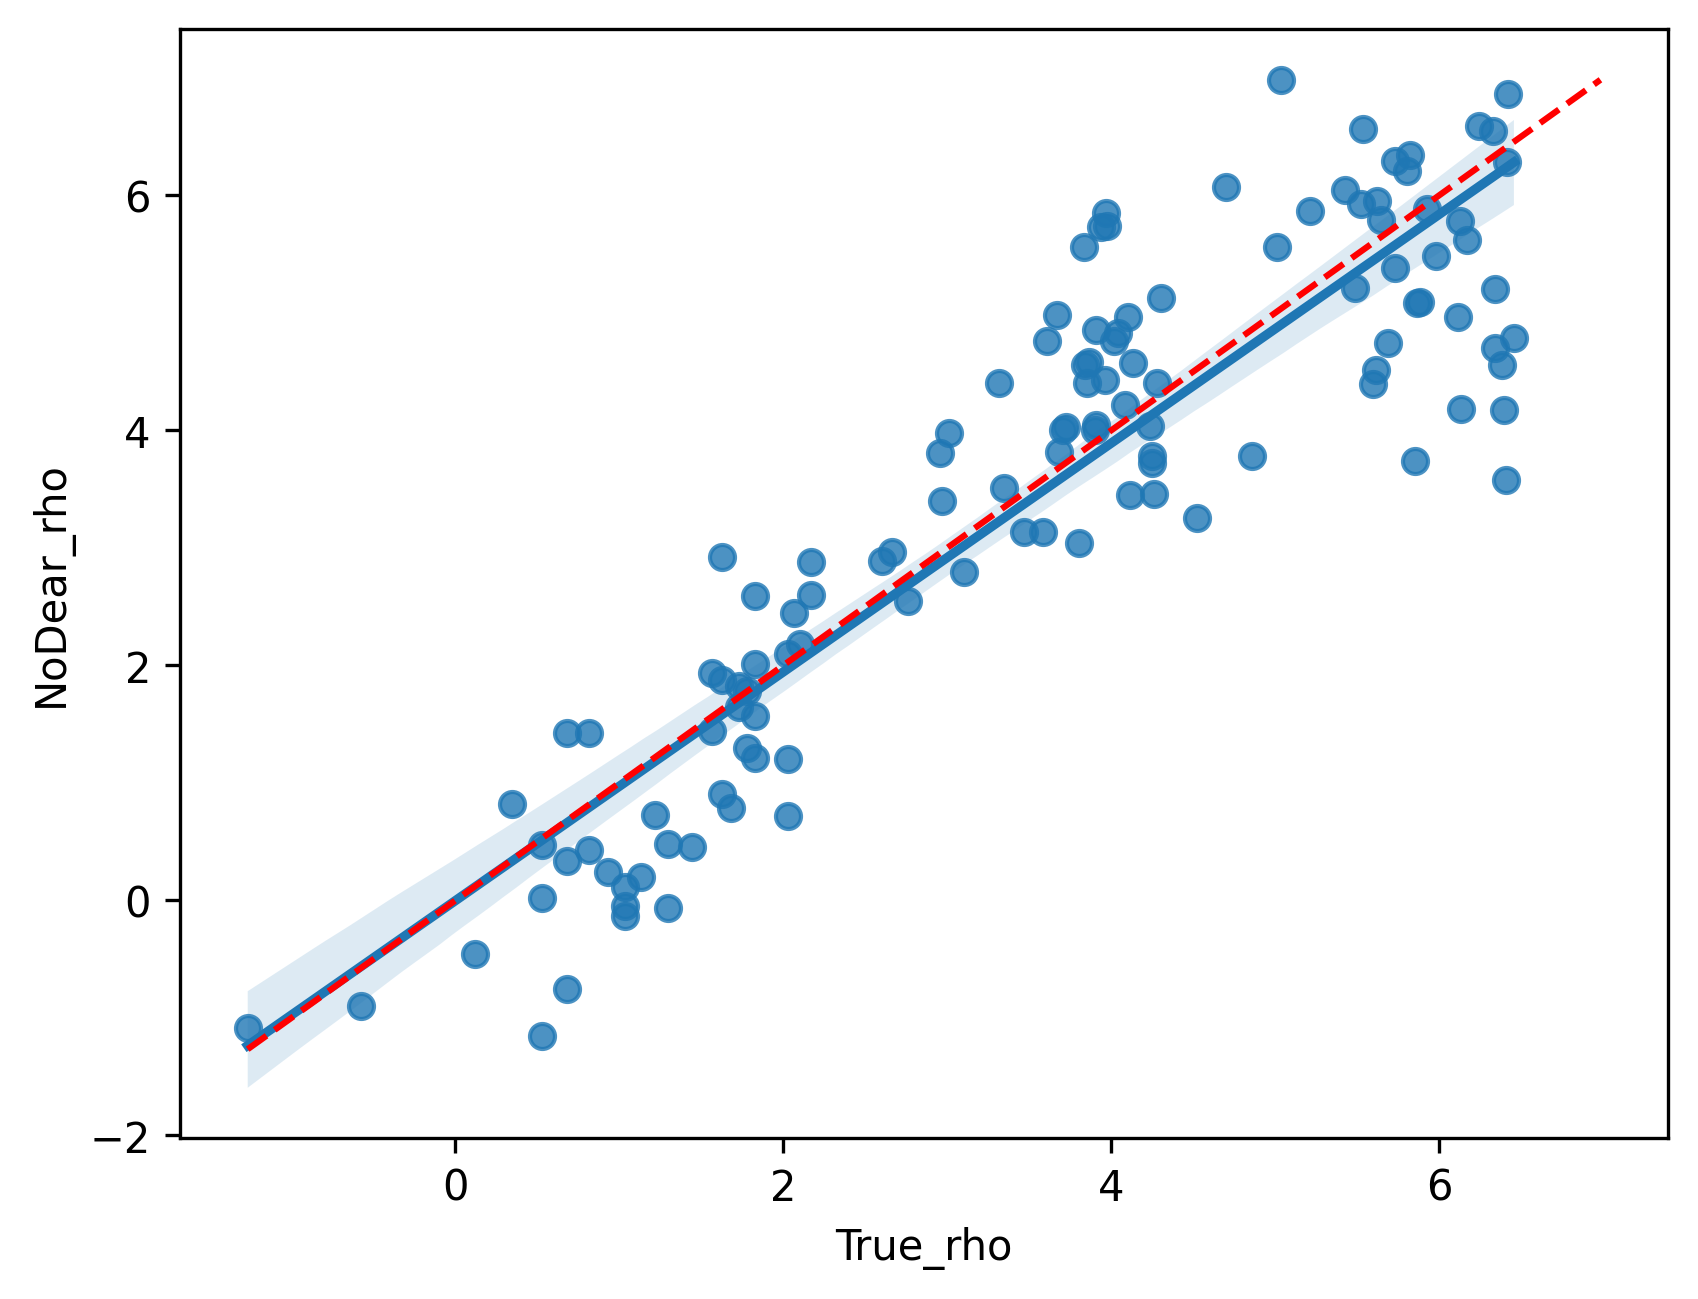

R2 Score: 0.7782409602951413
./eqtes_50k_100/
Speramanr: 0.8696683428750444
Pearsonr: 0.9014045566601383
0.8409579445367747
0.7324616725693055


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

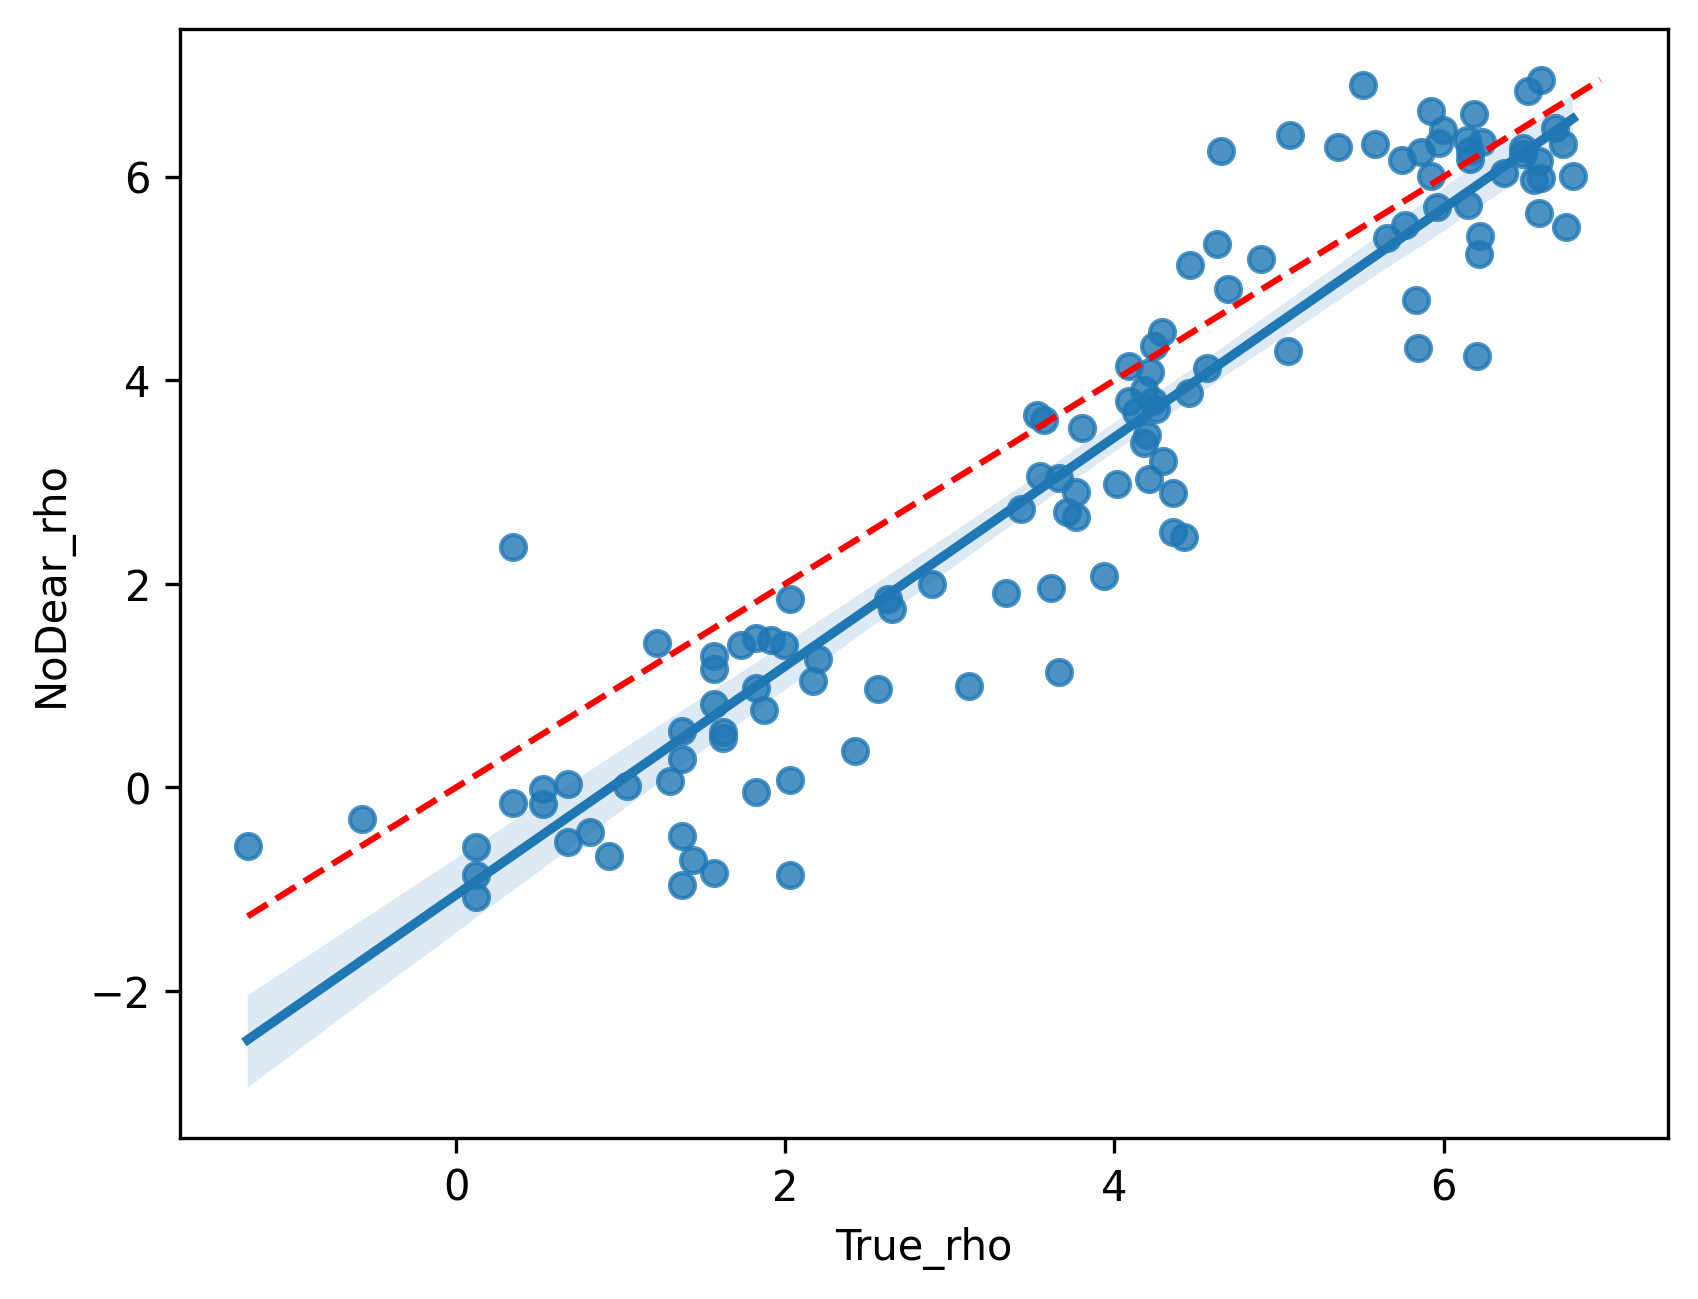

R2 Score: 0.7379187948322747
./eqtes_50k_100/
Speramanr: 0.9282347020234994
Pearsonr: 0.9406967331002312
1.1229570574145673
0.8533368203511831


<Figure size 640x480 with 0 Axes>

{'Folder': ['NoDeareqtes_50k_derived_rho',
  'NoDearnoneqtes_50k_derived_rho',
  'NoDearpopspliteq_50k_derived_rho',
  'NoDeargeneconversioneq_50k_derived_rho'],
 'R2_Score': [0.8131717988141142,
  0.8408510710703294,
  0.7782409602951413,
  0.7379187948322747],
 'Pearson_Correlation': [0.9277253932303624,
  0.9417226851026743,
  0.9014045566601383,
  0.9406967331002312],
 'Spearman_Correlation': [0.9227130690405193,
  0.9321715793727849,
  0.8696683428750444,
  0.9282347020234994],
 'Mean_square_error': [0.7072628987104117,
  0.7818313322565926,
  0.8409579445367747,
  1.1229570574145673]}

<Figure size 640x480 with 0 Axes>

In [124]:
results_dic = {'Folder':[], 'R2_Score':[], 'Pearson_Correlation':[], 'Spearman_Correlation':[],'Mean_square_error':[]}

df_=pd.read_csv('NoDear_training and Testing Results/NoDeareqtes_50k_derived_rho.csv')
df_.rename(columns={'NoDear_rho_derived': 'NoDear_rho'}, inplace=True)
dic_=df_.to_dict('list')
plotter(df_,'True_rho','NoDear_rho',results_dic,'NoDeareqtes_50k_derived_rho',dic_)

df_=pd.read_csv('NoDear_training and Testing Results/NoDearnoneqtes_50k_derived_rho.csv')
df_.rename(columns={'NoDear_rho_derived': 'NoDear_rho'}, inplace=True)
dic_=df_.to_dict('list')
plotter(df_,'True_rho','NoDear_rho',results_dic,'NoDearnoneqtes_50k_derived_rho',dic_)

df_=pd.read_csv('NoDear_training and Testing Results/NoDearpopspliteq_50k_derived_rho.csv')
df_.rename(columns={'NoDear_rho_derived': 'NoDear_rho'}, inplace=True)
dic_=df_.to_dict('list')
plotter(df_,'True_rho','NoDear_rho',results_dic,'NoDearpopspliteq_50k_derived_rho',dic_)


df_=pd.read_csv('NoDear_training and Testing Results/NoDeargeneconversioneq_50k_derived_rho.csv')
df_.rename(columns={'NoDear_rho_derived': 'NoDear_rho'}, inplace=True)
dic_=df_.to_dict('list')
plotter(df_,'True_rho','NoDear_rho',results_dic,'NoDeargeneconversioneq_50k_derived_rho',dic_)


# Extract pyrho results

<Figure size 640x480 with 0 Axes>

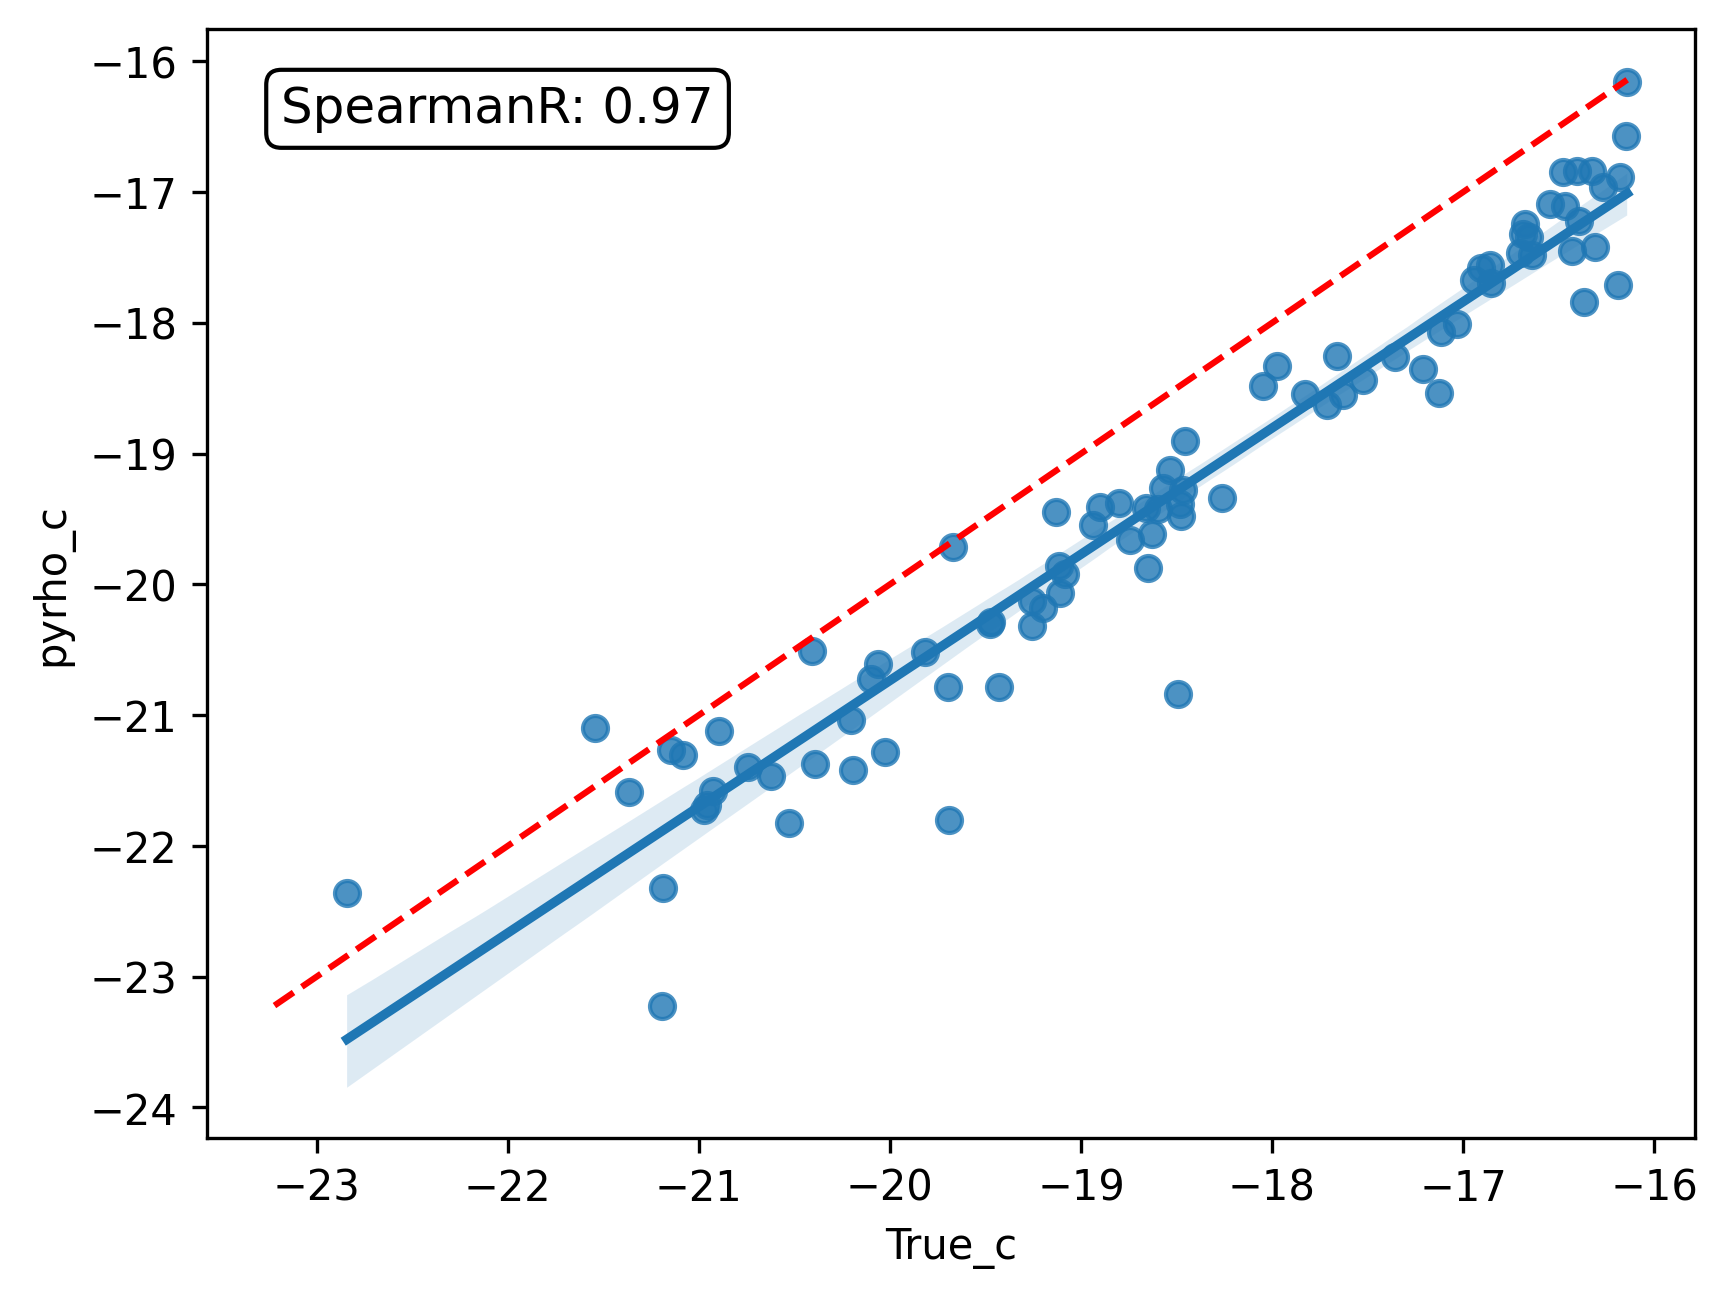

R2 Score: 0.7077947287706964
./noneqtes_50k/
Speramanr: 0.9662248219255625
Pearsonr: 0.964185377691757
0.8167447314743546
0.8066315734699068


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

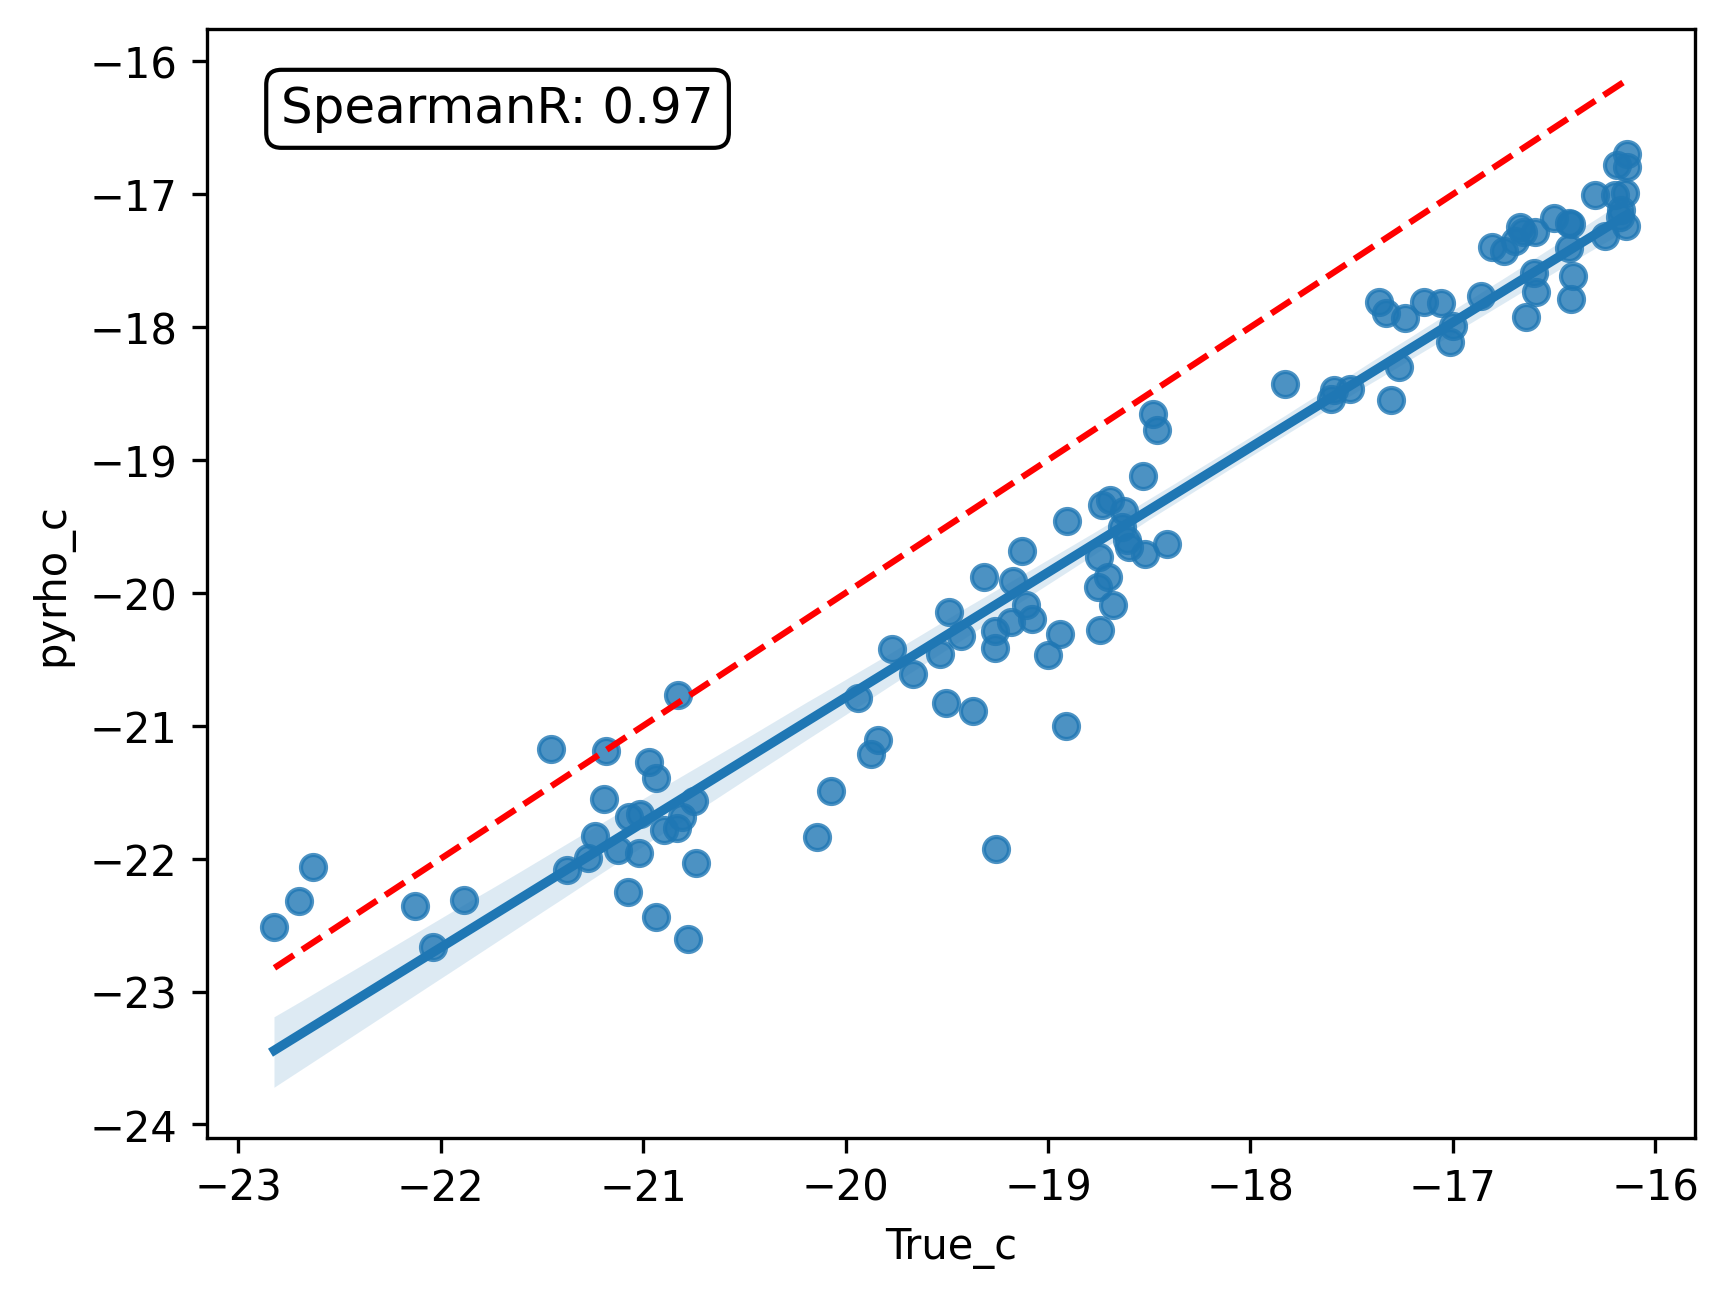

R2 Score: 0.7245097740529681
./eqtes_50k/
Speramanr: 0.9682007876329867
Pearsonr: 0.9678760353265203
0.9548402305314301
0.8875545291568138


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

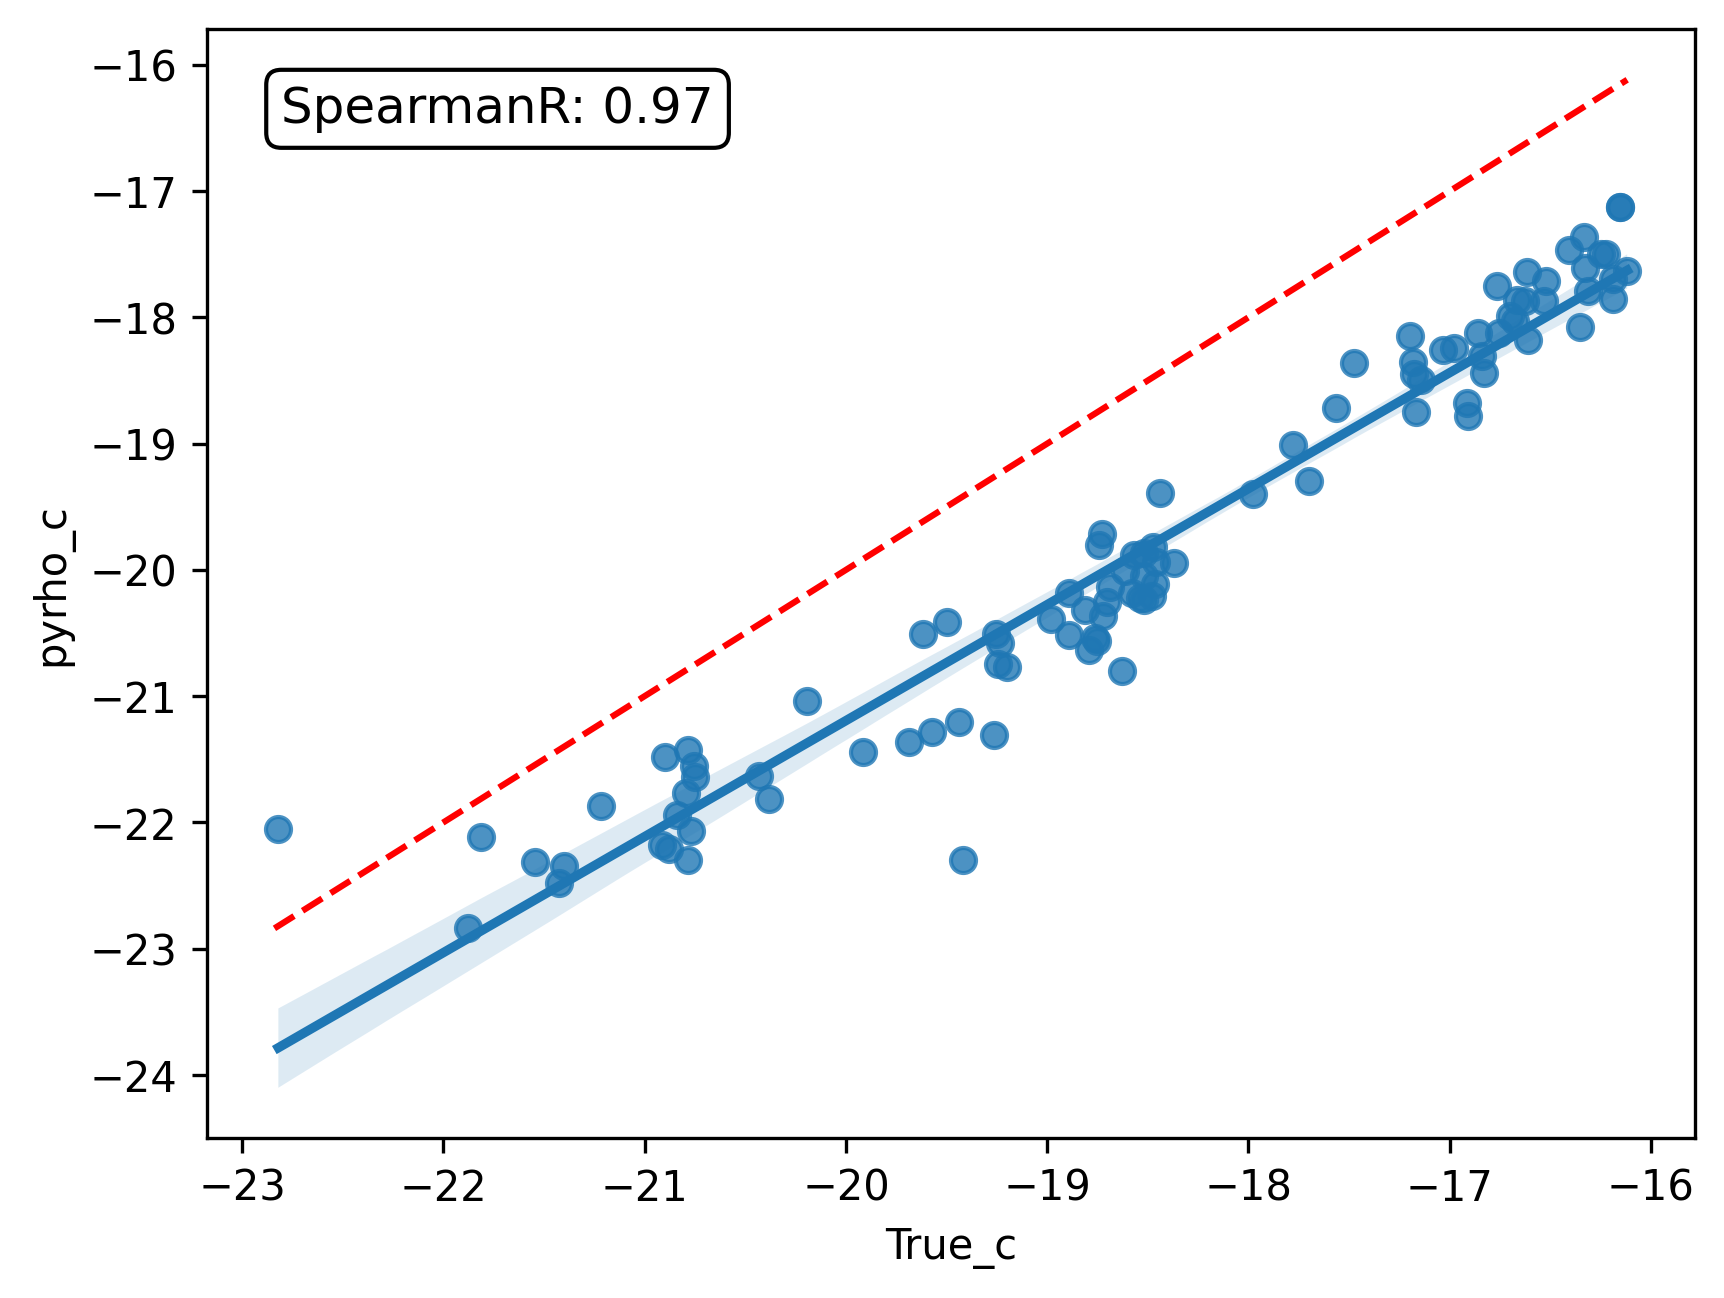

R2 Score: 0.32759256064186326
./geneconversioneq_50k/
Speramanr: 0.9735693246370712
Pearsonr: 0.9680625931959104
1.9137461690715982
1.3326298247298536


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

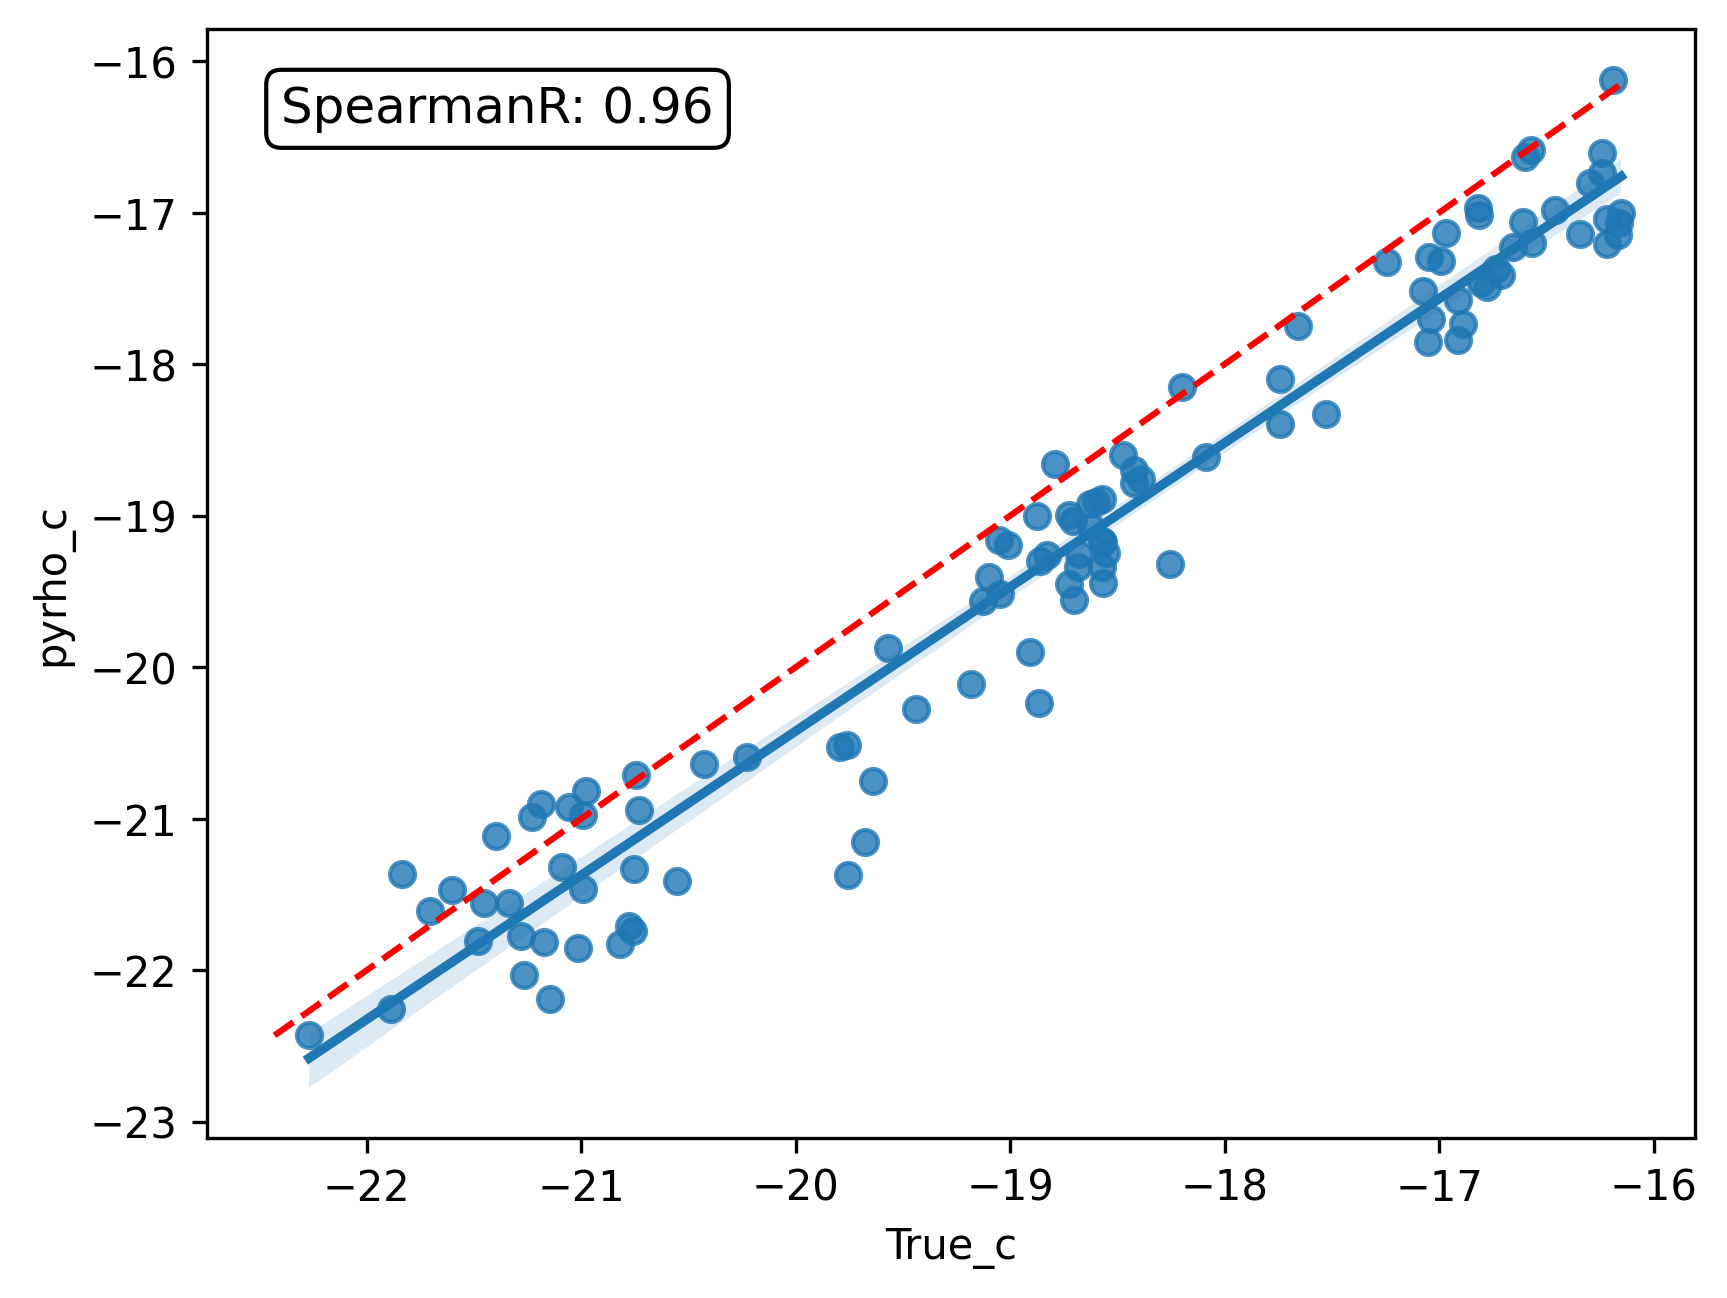

R2 Score: 0.8774811700101866
./popspliteq_50k/
Speramanr: 0.9631948118105763
Pearsonr: 0.9752566522961896
0.38451511146560313
0.5200755176864708


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [240]:
folder= ['./noneqtes_50k/','./eqtes_50k/','./geneconversioneq_50k/','./popspliteq_50k/']

from sklearn.metrics import mean_squared_error,mean_absolute_error
results_dic = {'Folder':[], 'R2_Score':[], 'Pearson_Correlation':[], 'Spearman_Correlation':[],'Mean_square_error':[]}
result_11={}
reject={'noneqtes_50k':[],'eqtes_50k':[],'geneconversioneq_50k':[],'popspliteq_50k':[]}
for fol in folder:
    

    pyc=[]
    true_c=[]
    vae=[]
    
    ha= np.load('/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear'+fol[1:]+fol[2:-1]+'_rec_rate.npy')
                
    reje=[]
    for i in range(120):
        try:
            op =open('/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear'+fol[1:]+str(i)+'.rmap')
            op_read =op.read().strip()
            op.close()



            
            recom=[]

            li_op= op_read.split('\n')

            upper= li_op[-1].split('\t')[1]
            lower= li_op[0].split('\t')[0]
            for j in li_op:
                v_1 = j.split('\t')
                v_2 = (int(v_1[1])-int(v_1[0]))* float(v_1[2])
                vae.append(int(v_1[1])-int(v_1[0]))
                recom.append(v_2)
                
            avg_1=sum(recom)/(int(upper)-int(lower))   
            if avg_1 > 1e-17:
                true_c.append(ha[i])
                pyc.append(avg_1)

        except:
            reject[fol[2:-1]].append(i)
            continue
        #re.append(sum(recom)/(int(upper)-int(lower)))
        

    dic_c = {'True_c': np.log(np.array(true_c)), 'pyrho_c':  np.log(pyc)}
    #print(dic_c)


    df_c = pd.DataFrame(dic_c)
    df_c.to_csv('pyrho'+fol[2:-1]+'_c.csv', index=False)
                
    





                
    plt.clf()
    results_dic= plotter(df_c,'True_c','pyrho_c',results_dic,fol[2:-1]+'_pyrho_c',dic_c)
    
    results_df.to_csv('pyrho_test_results.csv', index=False)
    

# Running Human Genome (FIN Chr-6) source: 'ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase1/analysis_results/integrated_call_sets/ALL.chr6.integrated_phase1_v3.20101123.snps_indels_svs.genotypes.vcf.gz'

In [261]:

oep =open('/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/url_list_fin.txt')
oep_r =oep.read()
oep.close()
url=[]
for ie in oep_r.strip().split('\n'):
    url.append(ie.split(' 	')[0])


urls = []
chromosome_names = []

for ii in url:
    chromosome_names.append(ii.split('chr')[1].split('.')[0])


## Use Pysam to extract genotype from VCF and use NoDEAR to predict rho

6 ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase1/analysis_results/integrated_call_sets/ALL.chr6.integrated_phase1_v3.20101123.snps_indels_svs.genotypes.vcf.gz
0-50000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_0_50000.vcf


/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


0
50000-100000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_50000_100000.vcf
2
100000-150000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_100000_150000.vcf
5
150000-200000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_150000_200000.vcf
5
200000-250000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_200000_250000.vcf
199
250000-300000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_250000_300000.vcf
85
300000-350000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_300000_350000.vcf
37
350000-400000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_350000_400000.vcf
75
400000-450000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_400000_450000.vcf
179
450000-500000
/N/slate/samishr/Recombination_landscape_9_

190
3450000-3500000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_3450000_3500000.vcf
151
3500000-3550000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_3500000_3550000.vcf
113
3550000-3600000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_3550000_3600000.vcf
127
3600000-3650000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_3600000_3650000.vcf
186
3650000-3700000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_3650000_3700000.vcf
218
3700000-3750000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_3700000_3750000.vcf
281
3750000-3800000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_3750000_3800000.vcf
242
3800000-3850000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_3800000_3850000.vcf
146
3850000-3900

247
6850000-6900000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_6850000_6900000.vcf
191
6900000-6950000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_6900000_6950000.vcf
285
6950000-7000000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_6950000_7000000.vcf
281
7000000-7050000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_7000000_7050000.vcf
208
7050000-7100000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_7050000_7100000.vcf
107
7100000-7150000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_7100000_7150000.vcf
92
7150000-7200000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_7150000_7200000.vcf
94
7200000-7250000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_7200000_7250000.vcf
99
7250000-7300000

167
10250000-10300000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_10250000_10300000.vcf
260
10300000-10350000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_10300000_10350000.vcf
160
10350000-10400000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_10350000_10400000.vcf
158
10400000-10450000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_10400000_10450000.vcf
120
10450000-10500000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_10450000_10500000.vcf
328
10500000-10550000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_10500000_10550000.vcf
148
10550000-10600000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_10550000_10600000.vcf
163
10600000-10650000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_106000

141
13550000-13600000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_13550000_13600000.vcf
83
13600000-13650000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_13600000_13650000.vcf
66
13650000-13700000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_13650000_13700000.vcf
52
13700000-13750000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_13700000_13750000.vcf
125
13750000-13800000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_13750000_13800000.vcf
174
13800000-13850000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_13800000_13850000.vcf
108
13850000-13900000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_13850000_13900000.vcf
259
13900000-13950000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_13900000_

116
16850000-16900000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_16850000_16900000.vcf
87
16900000-16950000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_16900000_16950000.vcf
132
16950000-17000000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_16950000_17000000.vcf
119
17000000-17050000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_17000000_17050000.vcf
183
17050000-17100000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_17050000_17100000.vcf
91
17100000-17150000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_17100000_17150000.vcf
115
17150000-17200000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_17150000_17200000.vcf
113
17200000-17250000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_17200000

140
20150000-20200000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_20150000_20200000.vcf
173
20200000-20250000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_20200000_20250000.vcf
148
20250000-20300000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_20250000_20300000.vcf
153
20300000-20350000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_20300000_20350000.vcf
122
20350000-20400000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_20350000_20400000.vcf
92
20400000-20450000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_20400000_20450000.vcf
95
20450000-20500000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_20450000_20500000.vcf
100
20500000-20550000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_20500000

174
23450000-23500000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_23450000_23500000.vcf
102
23500000-23550000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_23500000_23550000.vcf
123
23550000-23600000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_23550000_23600000.vcf
190
23600000-23650000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_23600000_23650000.vcf
182
23650000-23700000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_23650000_23700000.vcf
239
23700000-23750000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_23700000_23750000.vcf
272
23750000-23800000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_23750000_23800000.vcf
365
23800000-23850000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_238000

124
26700000-26750000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_26700000_26750000.vcf
78
26750000-26800000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_26750000_26800000.vcf
83
26800000-26850000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_26800000_26850000.vcf
96
26850000-26900000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_26850000_26900000.vcf
164
26900000-26950000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_26900000_26950000.vcf
139
26950000-27000000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_26950000_27000000.vcf
172
27000000-27050000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_27000000_27050000.vcf
127
27050000-27100000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_27050000_

1449
29950000-30000000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_29950000_30000000.vcf
450
30000000-30050000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_30000000_30050000.vcf
289
30050000-30100000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_30050000_30100000.vcf
385
30100000-30150000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_30100000_30150000.vcf
357
30150000-30200000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_30150000_30200000.vcf
210
30200000-30250000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_30200000_30250000.vcf
317
30250000-30300000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_30250000_30300000.vcf
185
30300000-30350000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_30300

107
33350000-33400000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_33350000_33400000.vcf
71
33400000-33450000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_33400000_33450000.vcf
103
33450000-33500000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_33450000_33500000.vcf
176
33500000-33550000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_33500000_33550000.vcf
254
33550000-33600000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_33550000_33600000.vcf
237
33600000-33650000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_33600000_33650000.vcf
211
33650000-33700000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_33650000_33700000.vcf
176
33700000-33750000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_3370000

127
36700000-36750000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_36700000_36750000.vcf
201
36750000-36800000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_36750000_36800000.vcf
134
36800000-36850000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_36800000_36850000.vcf
161
36850000-36900000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_36850000_36900000.vcf
152
36900000-36950000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_36900000_36950000.vcf
211
36950000-37000000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_36950000_37000000.vcf
150
37000000-37050000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_37000000_37050000.vcf
146
37050000-37100000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_370500

143
40000000-40050000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_40000000_40050000.vcf
108
40050000-40100000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_40050000_40100000.vcf
148
40100000-40150000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_40100000_40150000.vcf
208
40150000-40200000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_40150000_40200000.vcf
201
40200000-40250000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_40200000_40250000.vcf
156
40250000-40300000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_40250000_40300000.vcf
154
40300000-40350000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_40300000_40350000.vcf
214
40350000-40400000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_403500

117
43250000-43300000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_43250000_43300000.vcf
87
43300000-43350000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_43300000_43350000.vcf
70
43350000-43400000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_43350000_43400000.vcf
118
43400000-43450000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_43400000_43450000.vcf
62
43450000-43500000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_43450000_43500000.vcf
18
43500000-43550000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_43500000_43550000.vcf
25
43550000-43600000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_43550000_43600000.vcf
18
43600000-43650000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_43600000_436

122
46600000-46650000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_46600000_46650000.vcf
70
46650000-46700000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_46650000_46700000.vcf
61
46700000-46750000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_46700000_46750000.vcf
92
46750000-46800000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_46750000_46800000.vcf
130
46800000-46850000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_46800000_46850000.vcf
192
46850000-46900000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_46850000_46900000.vcf
111
46900000-46950000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_46900000_46950000.vcf
240
46950000-47000000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_46950000_

143
49850000-49900000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_49850000_49900000.vcf
134
49900000-49950000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_49900000_49950000.vcf
148
49950000-50000000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_49950000_50000000.vcf
123
50000000-50050000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_50000000_50050000.vcf
97
50050000-50100000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_50050000_50100000.vcf
115
50100000-50150000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_50100000_50150000.vcf
209
50150000-50200000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_50150000_50200000.vcf
151
50200000-50250000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_5020000

163
53150000-53200000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_53150000_53200000.vcf
163
53200000-53250000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_53200000_53250000.vcf
170
53250000-53300000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_53250000_53300000.vcf
103
53300000-53350000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_53300000_53350000.vcf
133
53350000-53400000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_53350000_53400000.vcf
217
53400000-53450000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_53400000_53450000.vcf
157
53450000-53500000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_53450000_53500000.vcf
173
53500000-53550000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_535000

138
56400000-56450000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_56400000_56450000.vcf
130
56450000-56500000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_56450000_56500000.vcf
96
56500000-56550000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_56500000_56550000.vcf
82
56550000-56600000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_56550000_56600000.vcf
89
56600000-56650000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_56600000_56650000.vcf
70
56650000-56700000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_56650000_56700000.vcf
105
56700000-56750000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_56700000_56750000.vcf
101
56750000-56800000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_56750000_5

/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encou

0
58900000-58950000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_58900000_58950000.vcf
0
58950000-59000000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_58950000_59000000.vcf
0
59000000-59050000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_59000000_59050000.vcf
0
59050000-59100000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_59050000_59100000.vcf
0
59100000-59150000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_59100000_59150000.vcf
0
59150000-59200000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_59150000_59200000.vcf
0
59200000-59250000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_59200000_59250000.vcf
0
59250000-59300000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_59250000_59300000.vcf


/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encou

0
59300000-59350000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_59300000_59350000.vcf
0
59350000-59400000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_59350000_59400000.vcf
0
59400000-59450000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_59400000_59450000.vcf
0
59450000-59500000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_59450000_59500000.vcf
0
59500000-59550000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_59500000_59550000.vcf
0
59550000-59600000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_59550000_59600000.vcf


/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encou

0
59600000-59650000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_59600000_59650000.vcf
0
59650000-59700000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_59650000_59700000.vcf
0
59700000-59750000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_59700000_59750000.vcf
0
59750000-59800000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_59750000_59800000.vcf
0
59800000-59850000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_59800000_59850000.vcf
0
59850000-59900000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_59850000_59900000.vcf
0
59900000-59950000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_59900000_59950000.vcf
0
59950000-60000000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_59950000_60000000.vcf


/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encou

0
60000000-60050000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_60000000_60050000.vcf
0
60050000-60100000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_60050000_60100000.vcf
0
60100000-60150000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_60100000_60150000.vcf
0
60150000-60200000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_60150000_60200000.vcf
0
60200000-60250000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_60200000_60250000.vcf
0
60250000-60300000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_60250000_60300000.vcf


/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


0
60300000-60350000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_60300000_60350000.vcf
0
60350000-60400000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_60350000_60400000.vcf
0
60400000-60450000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_60400000_60450000.vcf
0
60450000-60500000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_60450000_60500000.vcf
0
60500000-60550000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_60500000_60550000.vcf


/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


0
60550000-60600000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_60550000_60600000.vcf
0
60600000-60650000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_60600000_60650000.vcf
0
60650000-60700000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_60650000_60700000.vcf


/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encou

0
60700000-60750000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_60700000_60750000.vcf
0
60750000-60800000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_60750000_60800000.vcf
0
60800000-60850000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_60800000_60850000.vcf
0
60850000-60900000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_60850000_60900000.vcf
0
60900000-60950000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_60900000_60950000.vcf
0
60950000-61000000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_60950000_61000000.vcf


/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


0
61000000-61050000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_61000000_61050000.vcf
0
61050000-61100000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_61050000_61100000.vcf


/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


0
61100000-61150000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_61100000_61150000.vcf
0
61150000-61200000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_61150000_61200000.vcf


/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encou

0
61200000-61250000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_61200000_61250000.vcf
0
61250000-61300000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_61250000_61300000.vcf
0
61300000-61350000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_61300000_61350000.vcf
0
61350000-61400000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_61350000_61400000.vcf
0
61400000-61450000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_61400000_61450000.vcf
61450000-61500000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_61450000_61500000.vcf
0
61500000-61550000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_61500000_61550000.vcf


/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


0
61550000-61600000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_61550000_61600000.vcf
0
61600000-61650000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_61600000_61650000.vcf
61650000-61700000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_61650000_61700000.vcf
61700000-61750000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_61700000_61750000.vcf
61750000-61800000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_61750000_61800000.vcf
61800000-61850000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_61800000_61850000.vcf
61850000-61900000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_61850000_61900000.vcf
61900000-61950000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_61900000_61950000.vcf
61950000-620

95
64850000-64900000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_64850000_64900000.vcf
76
64900000-64950000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_64900000_64950000.vcf
108
64950000-65000000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_64950000_65000000.vcf
180
65000000-65050000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_65000000_65050000.vcf
165
65050000-65100000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_65050000_65100000.vcf
140
65100000-65150000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_65100000_65150000.vcf
138
65150000-65200000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_65150000_65200000.vcf
151
65200000-65250000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_65200000

220
68150000-68200000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_68150000_68200000.vcf
189
68200000-68250000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_68200000_68250000.vcf
148
68250000-68300000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_68250000_68300000.vcf
132
68300000-68350000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_68300000_68350000.vcf
70
68350000-68400000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_68350000_68400000.vcf
85
68400000-68450000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_68400000_68450000.vcf
172
68450000-68500000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_68450000_68500000.vcf
147
68500000-68550000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_68500000

65
71400000-71450000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_71400000_71450000.vcf
74
71450000-71500000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_71450000_71500000.vcf
82
71500000-71550000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_71500000_71550000.vcf
67
71550000-71600000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_71550000_71600000.vcf
88
71600000-71650000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_71600000_71650000.vcf
107
71650000-71700000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_71650000_71700000.vcf
191
71700000-71750000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_71700000_71750000.vcf
218
71750000-71800000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_71750000_71

198
74750000-74800000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_74750000_74800000.vcf
294
74800000-74850000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_74800000_74850000.vcf
150
74850000-74900000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_74850000_74900000.vcf
192
74900000-74950000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_74900000_74950000.vcf
170
74950000-75000000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_74950000_75000000.vcf
188
75000000-75050000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_75000000_75050000.vcf
95
75050000-75100000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_75050000_75100000.vcf
154
75100000-75150000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_7510000

155
78050000-78100000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_78050000_78100000.vcf
127
78100000-78150000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_78100000_78150000.vcf
175
78150000-78200000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_78150000_78200000.vcf
131
78200000-78250000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_78200000_78250000.vcf
232
78250000-78300000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_78250000_78300000.vcf
187
78300000-78350000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_78300000_78350000.vcf
152
78350000-78400000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_78350000_78400000.vcf
112
78400000-78450000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_784000

135
81300000-81350000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_81300000_81350000.vcf
126
81350000-81400000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_81350000_81400000.vcf
151
81400000-81450000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_81400000_81450000.vcf
147
81450000-81500000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_81450000_81500000.vcf
119
81500000-81550000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_81500000_81550000.vcf
128
81550000-81600000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_81550000_81600000.vcf
193
81600000-81650000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_81600000_81650000.vcf
184
81650000-81700000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_816500

97
84650000-84700000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_84650000_84700000.vcf
99
84700000-84750000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_84700000_84750000.vcf
70
84750000-84800000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_84750000_84800000.vcf
121
84800000-84850000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_84800000_84850000.vcf
84
84850000-84900000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_84850000_84900000.vcf
80
84900000-84950000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_84900000_84950000.vcf
66
84950000-85000000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_84950000_85000000.vcf
64
85000000-85050000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_85000000_8505

89
88000000-88050000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_88000000_88050000.vcf
143
88050000-88100000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_88050000_88100000.vcf
138
88100000-88150000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_88100000_88150000.vcf
174
88150000-88200000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_88150000_88200000.vcf
126
88200000-88250000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_88200000_88250000.vcf
121
88250000-88300000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_88250000_88300000.vcf
110
88300000-88350000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_88300000_88350000.vcf
92
88350000-88400000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_88350000

161
91250000-91300000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_91250000_91300000.vcf
71
91300000-91350000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_91300000_91350000.vcf
186
91350000-91400000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_91350000_91400000.vcf
207
91400000-91450000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_91400000_91450000.vcf
147
91450000-91500000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_91450000_91500000.vcf
114
91500000-91550000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_91500000_91550000.vcf
136
91550000-91600000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_91550000_91600000.vcf
181
91600000-91650000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_9160000

122
94650000-94700000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_94650000_94700000.vcf
77
94700000-94750000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_94700000_94750000.vcf
107
94750000-94800000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_94750000_94800000.vcf
170
94800000-94850000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_94800000_94850000.vcf
126
94850000-94900000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_94850000_94900000.vcf
96
94900000-94950000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_94900000_94950000.vcf
138
94950000-95000000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_94950000_95000000.vcf
109
95000000-95050000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_95000000

/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


65
95850000-95900000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_95850000_95900000.vcf
148
95900000-95950000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_95900000_95950000.vcf
136
95950000-96000000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_95950000_96000000.vcf
143
96000000-96050000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_96000000_96050000.vcf
170
96050000-96100000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_96050000_96100000.vcf
147
96100000-96150000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_96100000_96150000.vcf
200
96150000-96200000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_96150000_96200000.vcf
135
96200000-96250000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_9620000

56
99150000-99200000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_99150000_99200000.vcf
47
99200000-99250000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_99200000_99250000.vcf
158
99250000-99300000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_99250000_99300000.vcf
107
99300000-99350000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_99300000_99350000.vcf
141
99350000-99400000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_99350000_99400000.vcf
91
99400000-99450000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_99400000_99450000.vcf
117
99450000-99500000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_99450000_99500000.vcf
195
99500000-99550000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_99500000_

129
102350000-102400000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_102350000_102400000.vcf
190
102400000-102450000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_102400000_102450000.vcf
112
102450000-102500000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_102450000_102500000.vcf
171
102500000-102550000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_102500000_102550000.vcf
66
102550000-102600000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_102550000_102600000.vcf
54
102600000-102650000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_102600000_102650000.vcf
142
102650000-102700000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_102650000_102700000.vcf
141
102700000-102750000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/

79
105500000-105550000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_105500000_105550000.vcf
113
105550000-105600000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_105550000_105600000.vcf
131
105600000-105650000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_105600000_105650000.vcf
107
105650000-105700000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_105650000_105700000.vcf
164
105700000-105750000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_105700000_105750000.vcf
149
105750000-105800000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_105750000_105800000.vcf
192
105800000-105850000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_105800000_105850000.vcf
151
105850000-105900000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear

85
108700000-108750000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_108700000_108750000.vcf
114
108750000-108800000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_108750000_108800000.vcf
111
108800000-108850000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_108800000_108850000.vcf
69
108850000-108900000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_108850000_108900000.vcf
136
108900000-108950000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_108900000_108950000.vcf
78
108950000-109000000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_108950000_109000000.vcf
76
109000000-109050000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_109000000_109050000.vcf
189
109050000-109100000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/hu

99
111850000-111900000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_111850000_111900000.vcf
102
111900000-111950000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_111900000_111950000.vcf
181
111950000-112000000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_111950000_112000000.vcf
235
112000000-112050000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_112000000_112050000.vcf
92
112050000-112100000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_112050000_112100000.vcf
115
112100000-112150000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_112100000_112150000.vcf
96
112150000-112200000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_112150000_112200000.vcf
82
112200000-112250000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/hu

143
115050000-115100000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_115050000_115100000.vcf
155
115100000-115150000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_115100000_115150000.vcf
201
115150000-115200000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_115150000_115200000.vcf
137
115200000-115250000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_115200000_115250000.vcf
205
115250000-115300000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_115250000_115300000.vcf
151
115300000-115350000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_115300000_115350000.vcf
211
115350000-115400000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_115350000_115400000.vcf
195
115400000-115450000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDea

121
118250000-118300000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_118250000_118300000.vcf
108
118300000-118350000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_118300000_118350000.vcf
131
118350000-118400000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_118350000_118400000.vcf
157
118400000-118450000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_118400000_118450000.vcf
133
118450000-118500000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_118450000_118500000.vcf
100
118500000-118550000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_118500000_118550000.vcf
53
118550000-118600000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_118550000_118600000.vcf
68
118600000-118650000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/

146
121400000-121450000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_121400000_121450000.vcf
115
121450000-121500000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_121450000_121500000.vcf
100
121500000-121550000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_121500000_121550000.vcf
152
121550000-121600000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_121550000_121600000.vcf
70
121600000-121650000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_121600000_121650000.vcf
69
121650000-121700000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_121650000_121700000.vcf
152
121700000-121750000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_121700000_121750000.vcf
256
121750000-121800000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/

107
124600000-124650000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_124600000_124650000.vcf
163
124650000-124700000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_124650000_124700000.vcf
247
124700000-124750000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_124700000_124750000.vcf
203
124750000-124800000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_124750000_124800000.vcf
146
124800000-124850000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_124800000_124850000.vcf
99
124850000-124900000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_124850000_124900000.vcf
106
124900000-124950000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_124900000_124950000.vcf
90
124950000-125000000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/

94
127800000-127850000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_127800000_127850000.vcf
152
127850000-127900000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_127850000_127900000.vcf
221
127900000-127950000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_127900000_127950000.vcf
112
127950000-128000000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_127950000_128000000.vcf
142
128000000-128050000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_128000000_128050000.vcf
118
128050000-128100000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_128050000_128100000.vcf
94
128100000-128150000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_128100000_128150000.vcf
74
128150000-128200000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/h

226
130950000-131000000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_130950000_131000000.vcf
137
131000000-131050000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_131000000_131050000.vcf
129
131050000-131100000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_131050000_131100000.vcf
168
131100000-131150000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_131100000_131150000.vcf
174
131150000-131200000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_131150000_131200000.vcf
126
131200000-131250000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_131200000_131250000.vcf
89
131250000-131300000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_131250000_131300000.vcf
114
131300000-131350000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear

79
134100000-134150000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_134100000_134150000.vcf
95
134150000-134200000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_134150000_134200000.vcf
112
134200000-134250000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_134200000_134250000.vcf
107
134250000-134300000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_134250000_134300000.vcf
108
134300000-134350000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_134300000_134350000.vcf
98
134350000-134400000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_134350000_134400000.vcf
71
134400000-134450000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_134400000_134450000.vcf
216
134450000-134500000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/hu

178
137300000-137350000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_137300000_137350000.vcf
85
137350000-137400000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_137350000_137400000.vcf
78
137400000-137450000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_137400000_137450000.vcf
157
137450000-137500000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_137450000_137500000.vcf
105
137500000-137550000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_137500000_137550000.vcf
104
137550000-137600000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_137550000_137600000.vcf
106
137600000-137650000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_137600000_137650000.vcf
141
137650000-137700000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/

73
140450000-140500000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_140450000_140500000.vcf
86
140500000-140550000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_140500000_140550000.vcf
75
140550000-140600000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_140550000_140600000.vcf
78
140600000-140650000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_140600000_140650000.vcf
78
140650000-140700000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_140650000_140700000.vcf
84
140700000-140750000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_140700000_140750000.vcf
63
140750000-140800000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_140750000_140800000.vcf
34
140800000-140850000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_

102
143600000-143650000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_143600000_143650000.vcf
136
143650000-143700000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_143650000_143700000.vcf
151
143700000-143750000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_143700000_143750000.vcf
128
143750000-143800000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_143750000_143800000.vcf
151
143800000-143850000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_143800000_143850000.vcf
130
143850000-143900000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_143850000_143900000.vcf
220
143900000-143950000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_143900000_143950000.vcf
198
143950000-144000000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDea

103
146750000-146800000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_146750000_146800000.vcf
117
146800000-146850000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_146800000_146850000.vcf
72
146850000-146900000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_146850000_146900000.vcf
64
146900000-146950000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_146900000_146950000.vcf
116
146950000-147000000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_146950000_147000000.vcf
134
147000000-147050000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_147000000_147050000.vcf
112
147050000-147100000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_147050000_147100000.vcf
137
147100000-147150000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/

74
149900000-149950000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_149900000_149950000.vcf
84
149950000-150000000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_149950000_150000000.vcf
104
150000000-150050000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_150000000_150050000.vcf
64
150050000-150100000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_150050000_150100000.vcf
134
150100000-150150000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_150100000_150150000.vcf
112
150150000-150200000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_150150000_150200000.vcf
95
150200000-150250000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_150200000_150250000.vcf
179
150250000-150300000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/hu

128
153100000-153150000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_153100000_153150000.vcf
221
153150000-153200000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_153150000_153200000.vcf
141
153200000-153250000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_153200000_153250000.vcf
189
153250000-153300000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_153250000_153300000.vcf
204
153300000-153350000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_153300000_153350000.vcf
151
153350000-153400000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_153350000_153400000.vcf
221
153400000-153450000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_153400000_153450000.vcf
180
153450000-153500000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDea

203
156350000-156400000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_156350000_156400000.vcf
112
156400000-156450000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_156400000_156450000.vcf
114
156450000-156500000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_156450000_156500000.vcf
189
156500000-156550000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_156500000_156550000.vcf
192
156550000-156600000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_156550000_156600000.vcf
142
156600000-156650000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_156600000_156650000.vcf
81
156650000-156700000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_156650000_156700000.vcf
92
156700000-156750000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/

159
159500000-159550000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_159500000_159550000.vcf
169
159550000-159600000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_159550000_159600000.vcf
272
159600000-159650000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_159600000_159650000.vcf
173
159650000-159700000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_159650000_159700000.vcf
205
159700000-159750000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_159700000_159750000.vcf
207
159750000-159800000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_159750000_159800000.vcf
128
159800000-159850000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_159800000_159850000.vcf
73
159850000-159900000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear

163
162700000-162750000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_162700000_162750000.vcf
195
162750000-162800000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_162750000_162800000.vcf
148
162800000-162850000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_162800000_162850000.vcf
215
162850000-162900000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_162850000_162900000.vcf
276
162900000-162950000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_162900000_162950000.vcf
278
162950000-163000000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_162950000_163000000.vcf
358
163000000-163050000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_163000000_163050000.vcf
253
163050000-163100000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDea

191
165850000-165900000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_165850000_165900000.vcf
117
165900000-165950000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_165900000_165950000.vcf
172
165950000-166000000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_165950000_166000000.vcf
122
166000000-166050000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_166000000_166050000.vcf
241
166050000-166100000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_166050000_166100000.vcf
140
166100000-166150000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_166100000_166150000.vcf
137
166150000-166200000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_166150000_166200000.vcf
162
166200000-166250000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDea

/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


29
168050000-168100000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_168050000_168100000.vcf
200
168100000-168150000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_168100000_168150000.vcf
228
168150000-168200000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_168150000_168200000.vcf
310
168200000-168250000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_168200000_168250000.vcf
182
168250000-168300000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_168250000_168300000.vcf
135
168300000-168350000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_168300000_168350000.vcf
180
168350000-168400000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_168350000_168400000.vcf
237
168400000-168450000
/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear

/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


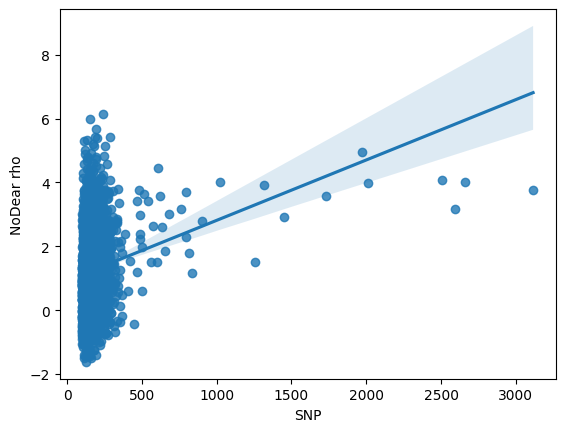

<Figure size 640x480 with 0 Axes>

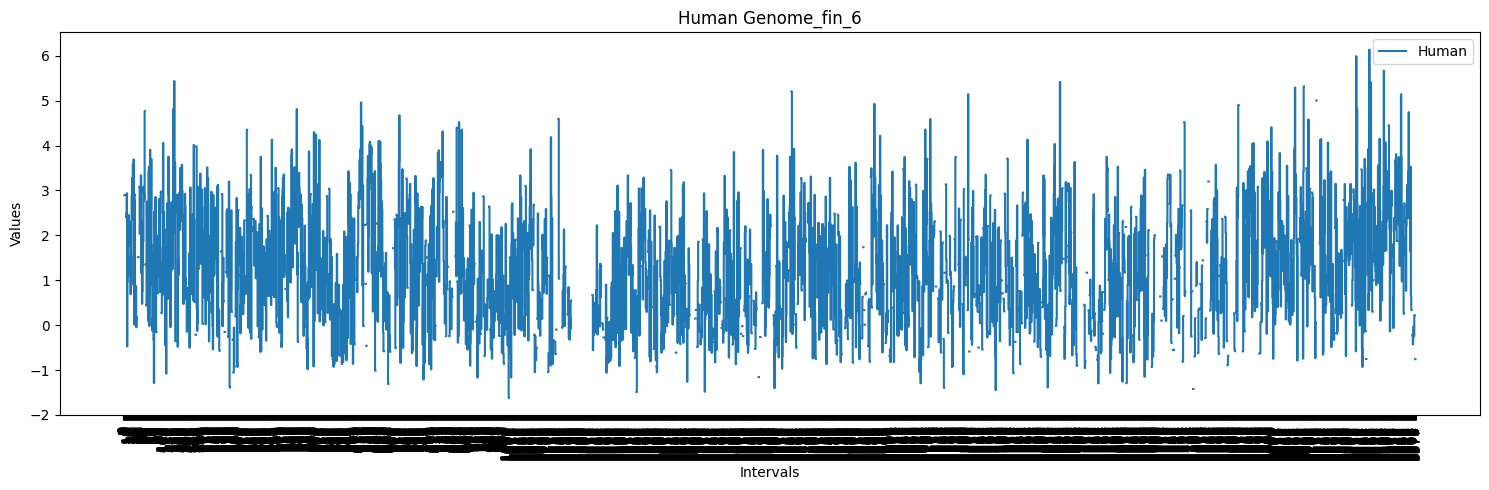

In [264]:

import pysam
import numpy as np
import os
import math
import time

os.environ["PATH"] = "/local/bin/bcftools:" + os.environ["PATH"]
rejected_interval=[]
time_=[]
for ur in url[:1]:
    pred_hu=[]
    chromosome_names= ur.split('chr')[1].split('.')[0]
    print(chromosome_names,ur)
    if ur[-4:]=='.tbi':
        ur=ur[:-4]
    
    count_snp=[]
    interval=[]   
    window_size=50000
    for k in range(0,3408):
        start= str(k*(50000))
        end=str((k+1)*50000)
                  
        print(str(k*(50000))+'-'+str((k+1)*50000))
        #print('tabix -h  	'+ur+' '+chromosome_names+':'+start+'-'+end+' > /N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_'+str(k*(50000))+'_'+str((k+1)*50000)+'.vcf')
        #os.system('tabix -h  	'+ur+' '+chromosome_names+':'+start+'-'+end+' > /N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_'+str(k*(50000))+'_'+str((k+1)*50000)+'.vcf')
 


        file_to_open= '/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/output_'+start+'_'+end+'.vcf'
        print(file_to_open)
        try:
            vcf_file = pysam.VariantFile(file_to_open)

            # Lists to store data
            data = []


            for record in vcf_file:
                        basic_info = [record.chrom, record.pos, record.ref]
                        genotypes = []
                        for sample in record.samples:
                            genotype = record.samples[sample]['GT']

                            genotype_str = [int(allele) if allele is not None else '.' for allele in genotype]

                            genotypes+=genotype_str




                        data.append(genotypes)


            start_time= time.time()
            genotype_array = np.array(data)

            predec ,SNP= predit(genotype_array,model_dic['train_50k'][0],0)
            time_.append(time.time()-start_time)
            print(SNP)
            ## Filtering for SNP
            if SNP>100:
                pred_hu.append(predec[0])
                count_snp.append(SNP)
                interval.append(str(start)+'-'+str(end))
            else:
                pred_hu.append(None)
                count_snp.append(SNP)
                interval.append(str(start)+'-'+str(end))
                rejected_interval.append(k)
            start= end
            end = str(int(end)+ window_size)
        except:
            start= end
            end = str(int(end)+ window_size)
            


    dic= {'Interval':interval, 'NoDear rho': pred_hu,'SNP':count_snp}
    print(dic)
    pd.DataFrame(dic).to_csv('Human_genome_FIN_6_50k.csv',index=False)


    sns.regplot(x='SNP', y='NoDear rho', data=pd.DataFrame(dic))
    plt.savefig('Human_genome_FIN_6_50k_SNP_rho.jpg')
    plt.show()
    plt.clf()


    file_= pd.read_csv('Human_genome_FIN_6_50k.csv')
    file_

    interval,another_y_set, SNP_=file_['Interval'], file_['NoDear rho'],file_['SNP']
    another_y_set= 1*((another_y_set))

    y_values2 = np.divide(another_y_set, 1)


    plt.figure(figsize=(15, 5))

    #lt.step(range(len(interval_list[:110])), y_values1[:110], where='mid', label='19')


    plt.step(range(len(y_values2)), y_values2, where='mid', label='Human')



    plt.xticks(range(len(y_values2)), range(len(y_values2)), rotation=90)

    plt.xlabel('Intervals')
    plt.ylabel('Values')
    plt.title('Human Genome_fin_6')
    plt.legend()  
    plt.tight_layout()
    plt.savefig('Human_genome_FIN_6_50k.jpg')
    plt.show()


# Plot the Landscape

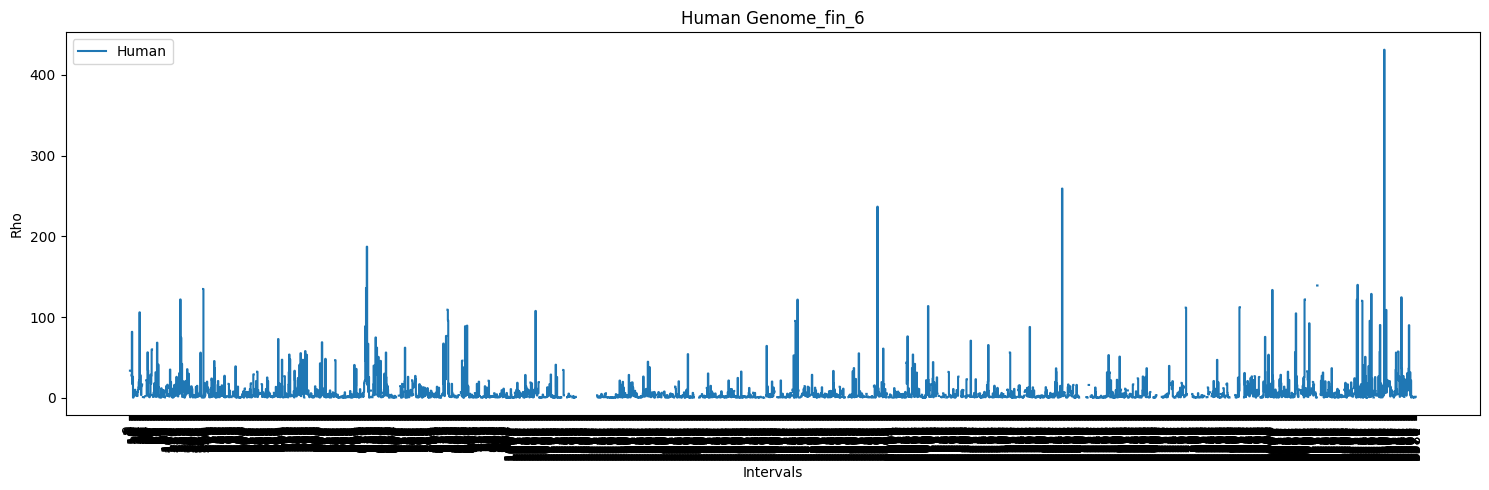

In [190]:
file_= pd.read_csv('./NoDear_training and Testing Results/Human_genome_FIN_6_50k.csv')
file_
interval,another_y_set, SNP_=file_['Interval'], file_['NoDear rho'],file_['SNP']
another_y_set= 1*((another_y_set))
y_values2 = np.divide(another_y_set, 1)


plt.figure(figsize=(15, 5))

   

plt.step(range(len(y_values2)), np.exp(y_values2), where='mid', label='Human')


plt.xticks(range(len(y_values2)), range(len(y_values2)), rotation=90)

plt.xlabel('Intervals')
plt.ylabel('Rho')
plt.title('Human Genome_fin_6')
plt.legend()  
plt.tight_layout()
plt.savefig('Human_genome_FIN_6_50k.jpg')
plt.show()


In [178]:
pd.DataFrame(np.exp(y_values2)).dropna().describe()

NoDear rho
count  2602.000000
mean      8.978789
std      21.731767
min       0.198076
25%       1.270675
50%       3.173630
75%       8.887615
max     460.728386

# Extract pyrho C values

In [244]:
re={'Interval':[],'pyrho C':[]}
snp=[]
vae=[]
reject=[]
for i in range(3408):

        file_name= 'output_'+str(i*(50000))+'_'+str((i+1)*50000)+'.rmap'
        try:
            
            op =open('/N/slate/samishr/Recombination_landscape_9_10/XGBOOST/NoDear/human_genome_1/results/'+file_name)
            op_read =op.read().strip()
            op.close()



            #snp.append(ha[i])
            recom=[]

            li_op= op_read.split('\n')

            upper= li_op[-1].split('\t')[1]
            lower= li_op[0].split('\t')[0]
            for j in li_op:
                v_1 = j.split('\t')
                v_2 = (int(v_1[1])-int(v_1[0]))* float(v_1[2])
                vae.append(int(v_1[1])-int(v_1[0]))
                recom.append(v_2)
            if sum(recom)/(int(upper)-int(lower))> 10e-11 and sum(recom)/(int(upper)-int(lower))<10e-7 :
                re['pyrho C']+=[sum(recom)/(int(upper)-int(lower))]
                re['Interval']+=[str(i*(50000))+'-'+str((i+1)*50000)]

        except:
            reject.append(str(i*(50000))+'_'+str((i+1)*50000))
            continue
    #re.append(sum(recom)/(int(upper)-int(lower)))
    

In [245]:
pd.DataFrame(re['pyrho C'],columns=['pyrho C']).describe()

pyrho C
count  3.053000e+03
mean   2.904264e-09
std    5.901750e-09
min    1.018952e-10
25%    6.582191e-10
50%    1.620469e-09
75%    3.487302e-09
max    1.510503e-07

In [211]:
re_df = pd.DataFrame(re)

In [213]:
file_= pd.read_csv('./NoDear_training and Testing Results/Human_genome_FIN_6_50k.csv')

In [214]:
file_

Interval  NoDear rho  SNP
0                 0-50000         NaN    0
1            50000-100000         NaN    2
2           100000-150000         NaN    5
3           150000-200000         NaN    5
4           200000-250000    3.519544  199
...                   ...         ...  ...
3377  170150000-170200000   -0.541624  157
3378  170200000-170250000   -0.362229  206
3379  170250000-170300000         NaN  100
3380  170300000-170350000    0.398043  122
3381  170350000-170400000         NaN    0

[3382 rows x 3 columns]

In [215]:
merged_df = pd.merge(file_, re_df, on=re_df.columns.intersection(file_.columns).tolist()
)

In [216]:
merged_df = merged_df.dropna()
merged_df

Interval  NoDear rho  SNP       pyrho C
2           200000-250000    3.519544  199  2.032993e-08
6           400000-450000    3.326206  179  4.153685e-09
7           450000-500000    4.405017  231  9.856029e-09
8           500000-550000    2.836839  145  3.676068e-09
9           550000-600000    3.271957  135  2.815669e-09
...                   ...         ...  ...           ...
3314  170000000-170050000   -0.599220  103  1.259182e-09
3315  170050000-170100000    0.225599  130  1.365814e-09
3317  170150000-170200000   -0.541624  157  8.559445e-10
3318  170200000-170250000   -0.362229  206  2.506266e-09
3320  170300000-170350000    0.398043  122  8.227860e-09

[2602 rows x 4 columns]

In [217]:
merged_df['pyrho C'] = np.log(merged_df['pyrho C'])
merged_df['SNP'] = np.log(merged_df['SNP'])

# Plot the correlation

In [ ]:
from scipy.stats import spearmanr,pearsonr
from sklearn.metrics import r2_score

rho_sp,p=spearmanr(merged_df['pyrho C'],merged_df['NoDear rho'])
rho_sp

sns.regplot(x='pyrho C', y='NoDear rho', data=merged_df)

plt.annotate(f'SpearmanR: {rho_sp:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, ha='left', va='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

plt.savefig('Human_genome_NoDear_pyrho.jpg')
plt.show()
plt.clf()

rho_sp

In [197]:
rho_sp,p=pearsonr(merged_df['pyrho C'],merged_df['NoDear rho'])
rho_sp

0.6077300067331398

In [92]:
merged_df

Interval  NoDear rho  SNP    pyrho C
0           200000-250000    3.519544  199 -17.711172
4           400000-450000    3.326206  179 -19.299270
5           450000-500000    4.405017  231 -18.435182
6           500000-550000    2.836839  145 -19.421422
7           550000-600000    3.271957  135 -19.688066
...                   ...         ...  ...        ...
3046  170000000-170050000   -0.599220  103 -20.492804
3047  170050000-170100000    0.225599  130 -20.411516
3049  170150000-170200000   -0.541624  157 -20.878816
3050  170200000-170250000   -0.362229  206 -19.804472
3052  170300000-170350000    0.398043  122 -18.615740

[2498 rows x 4 columns]